# Análise de Modelos Segmentados

Notebook para treinar e comparar modelos por fonte, tipo de negócio e dataset completo gerado pelo pipeline.


In [38]:
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_error,
    mean_absolute_percentage_error,
    median_absolute_error
)
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    ExtraTreesRegressor
)
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json

# Tentar importar TensorFlow (opcional)
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers, models, callbacks
    TENSORFLOW_AVAILABLE = True
    print("✓ TensorFlow disponível")
except ImportError:
    TENSORFLOW_AVAILABLE = False
    print("⚠ TensorFlow não disponível. Instale com: pip install tensorflow")

plt.style.use("seaborn-v0_8")
sns.set_palette("husl")


✓ TensorFlow disponível


In [39]:
from pathlib import Path

BASE_DATA_DIR = Path.cwd()
IN_COLAB = True

print(f"Diretório base de dados: {BASE_DATA_DIR}")
print(f"Executando no Colab: {IN_COLAB}")

Diretório base de dados: /content
Executando no Colab: True


In [40]:
DATA_ROOT = BASE_DATA_DIR / "dados_imoveis_teresina"
SEGMENT_DIR = DATA_ROOT / "segmentos"
FULL_DATASET = DATA_ROOT / "dataset_treino_ml_v1.csv" # Corrected path to DATA_ROOT
RESULTS_FILE = DATA_ROOT / "resultados_modelos.csv"
BEST_MODEL_DIR = DATA_ROOT / "modelos"
MIN_SAMPLES = 30
N_CV_FOLDS = 5

SEGMENT_DIR.mkdir(parents=True, exist_ok=True)
BEST_MODEL_DIR.mkdir(parents=True, exist_ok=True)

def list_datasets():
    datasets = []
    if FULL_DATASET.exists():
        datasets.append(("full", FULL_DATASET))
    for csv_path in sorted(SEGMENT_DIR.glob("dataset_*.csv")):
        name = csv_path.stem.replace("dataset_", "")
        datasets.append((name, csv_path))
    return datasets

datasets = list_datasets()
print(f"Encontrados {len(datasets)} datasets segmentados.")
datasets

Encontrados 2 datasets segmentados.


[('full',
  PosixPath('/content/dados_imoveis_teresina/dataset_treino_ml_v1.csv')),
 ('fonte_olx',
  PosixPath('/content/dados_imoveis_teresina/segmentos/dataset_fonte_olx.csv'))]

In [41]:
def train_and_evaluate(df: pd.DataFrame, dataset_name: str, use_cv: bool = True) -> dict:
    """
    Treina e avalia um modelo XGBoost para o dataset fornecido.

    Args:
        df: DataFrame com os dados
        dataset_name: Nome do dataset
        use_cv: Se True, realiza validação cruzada

    Returns:
        Dicionário com métricas, modelo treinado e informações adicionais
    """
    target_col = 'Valor_Anuncio'
    if target_col not in df.columns:
        raise ValueError(f"Coluna alvo '{target_col}' não encontrada em {dataset_name}.")

    if len(df) < MIN_SAMPLES:
        raise ValueError(f"Segmento '{dataset_name}' possui apenas {len(df)} registros.")

    X = df.drop(columns=[target_col]).select_dtypes(include=np.number)
    y = df[target_col]

    # Remove colunas com variância zero ou NaN
    X = X.loc[:, X.var() > 0].dropna(axis=1)

    if X.empty:
        raise ValueError(f"Nenhuma feature numérica válida encontrada em {dataset_name}.")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model = XGBRegressor(
        objective='reg:squarederror',
        n_estimators=200,
        learning_rate=0.08,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42,
    )

    # Treinamento
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Métricas no conjunto de teste
    rmse_test = float(np.sqrt(mean_squared_error(y_test, y_pred)))
    r2_test = float(r2_score(y_test, y_pred))
    mae_test = float(mean_absolute_error(y_test, y_pred))

    # MAPE com tratamento para valores zero
    mask = y_test != 0
    if mask.sum() > 0:
        mape_test = float(mean_absolute_percentage_error(y_test[mask], y_pred[mask])) * 100
    else:
        mape_test = np.nan

    # Erro percentual médio
    error_pct = np.abs((y_test - y_pred) / y_test) * 100
    mean_error_pct = float(error_pct[mask].mean()) if mask.sum() > 0 else np.nan

    # Validação cruzada
    cv_rmse_scores = None
    cv_r2_scores = None
    cv_rmse_mean = None
    cv_rmse_std = None
    cv_r2_mean = None
    cv_r2_std = None

    if use_cv and len(df) >= N_CV_FOLDS * 3:  # Precisa de amostras suficientes para CV
        kfold = KFold(n_splits=N_CV_FOLDS, shuffle=True, random_state=42)

        # CV para RMSE (neg_mean_squared_error retorna negativo, então negamos)
        cv_rmse_scores = -cross_val_score(
            model, X, y, cv=kfold, scoring='neg_mean_squared_error'
        )
        cv_rmse_scores = np.sqrt(cv_rmse_scores)  # Converte para RMSE

        # CV para R²
        cv_r2_scores = cross_val_score(model, X, y, cv=kfold, scoring='r2')

        cv_rmse_mean = float(cv_rmse_scores.mean())
        cv_rmse_std = float(cv_rmse_scores.std())
        cv_r2_mean = float(cv_r2_scores.mean())
        cv_r2_std = float(cv_r2_scores.std())

    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    return {
        'dataset': dataset_name,
        'n_samples': len(df),
        'n_features': len(X.columns),
        # Métricas no conjunto de teste
        'rmse_test': rmse_test,
        'r2_test': r2_test,
        'mae_test': mae_test,
        'mape_test': mape_test,
        'mean_error_pct': mean_error_pct,
        # Métricas de validação cruzada
        'cv_rmse_mean': cv_rmse_mean,
        'cv_rmse_std': cv_rmse_std,
        'cv_r2_mean': cv_r2_mean,
        'cv_r2_std': cv_r2_std,
        # Modelo e dados para análise posterior
        'model': model,
        'feature_names': X.columns.tolist(),
        'feature_importance': feature_importance,
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': y_pred,
    }



## Pré-processamento dedicado ao dataset principal

As células abaixo padronizam o dataset completo gerado pelo pipeline, eliminando
colunas de localização pouco confiáveis provenientes da fonte OLX e mapeando os
campos que estarão disponíveis no frontend (`área`, `quartos`, `banheiros`,
`tipo`, `bairro` e `cidade`). Dessa forma, garantimos que o conjunto de
features usado no treinamento será compatível com os dados enviados pelo botão
*Especulai* no aplicativo web.


In [42]:
LOCATION_COLUMNS = ['latitude', 'longitude', 'rua', 'numero', 'bairro_link']
PRIMARY_FEATURE_MAP = {
    'Valor_Anuncio': 'Valor_Anuncio',
    'area': 'Area_m2',
    'quartos': 'Quartos',
    'banheiros': 'Banheiros',
}
REQUIRED_COLUMNS = ['Valor_Anuncio', 'area', 'quartos', 'banheiros', 'tipo', 'bairro', 'cidade']


def sanitize_olx_locations(df: pd.DataFrame) -> pd.DataFrame:
    if 'fonte' not in df.columns:
        return df
    mask = df['fonte'].astype(str).str.lower() == 'olx'
    cols = [col for col in LOCATION_COLUMNS if col in df.columns]
    if cols:
        df.loc[mask, cols] = np.nan
    return df


def prepare_primary_dataset(csv_path: Path = FULL_DATASET) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    print(f"Original columns in CSV: {df.columns.tolist()}") # Debugging line
    df = sanitize_olx_locations(df)

    # --- Rename existing columns first --- (only those in PRIMARY_FEATURE_MAP and df.columns)
    actual_rename_map = {}
    for canonical_name, raw_name in PRIMARY_FEATURE_MAP.items():
        if raw_name in df.columns:
            actual_rename_map[raw_name] = canonical_name
    df = df.rename(columns=actual_rename_map)

    # --- Explicitly create/handle 'tipo', 'bairro', 'cidade' if not present after renaming ---
    # Handle 'bairro': Convert one-hot encoded 'Bairro_X' columns to a single 'bairro' column
    if 'bairro' not in df.columns: # Check if 'Bairro' was renamed to 'bairro' from a source column
        bairro_cols = [col for col in df.columns if col.startswith('Bairro_')]
        if bairro_cols:
            # Assuming only one Bairro_X column is 1 for each row. Creates 'Bairro_NomeDoBairro'
            df['bairro'] = df[bairro_cols].idxmax(axis=1).str.replace('Bairro_', '', regex=False)
            # Drop the one-hot encoded columns after creating the single 'bairro' column
            df = df.drop(columns=bairro_cols)
        else:
            df['bairro'] = 'Desconhecido' # Fallback if no Bairro_X columns either

    # Handle 'tipo': Assign a default value as it's not in original columns
    if 'tipo' not in df.columns: # Check if 'Tipo_Imovel' was renamed to 'tipo'
        df['tipo'] = 'Outros' # Default value as 'Tipo_Imovel' is missing

    # Handle 'cidade': Assign a default value as it's not in original columns
    if 'cidade' not in df.columns: # Check if 'Municipio' was renamed to 'cidade'
        df['cidade'] = 'Teresina' # Default value, assuming context
    # ----------------------------------------------------------------------------------

    # Ensure all required columns are present after creation/renaming
    missing_cols = [col for col in REQUIRED_COLUMNS if col not in df.columns]
    if missing_cols:
        # This should ideally not be reached if logic above is correct for REQUIRED_COLUMNS
        raise ValueError(f"Colunas ausentes no dataset principal APÓS TRATAMENTO: {missing_cols}")

    df = df.dropna(subset=REQUIRED_COLUMNS)
    df['area'] = pd.to_numeric(df['area'], errors='coerce').clip(lower=1)
    df['quartos'] = pd.to_numeric(df['quartos'], errors='coerce')
    df['banheiros'] = pd.to_numeric(df['banheiros'], errors='coerce')

    df = df.dropna(subset=['area', 'quartos', 'banheiros'])

    # These operations will now work as 'tipo', 'bairro', 'cidade' are guaranteed to be strings
    df['tipo'] = df['tipo'].astype(str).str.lower().str.strip()
    df['bairro'] = df['bairro'].astype(str).str.title().str.strip()
    df['cidade'] = df['cidade'].astype(str).str.title().str.strip()
    df['densidade_comodos'] = (df['quartos'] + df['banheiros']) / df['area']

    df = df[df['area'] > 0]
    return df


primary_dataset = prepare_primary_dataset()
print(f"Dataset principal pronto com {len(primary_dataset)} registros")
primary_dataset.head()

Original columns in CSV: ['Area_m2', 'Quartos', 'Banheiros', 'Vagas_Garagem', 'Valor_Anuncio', 'URL_Anuncio', 'Data_Coleta', 'Latitude', 'Longitude', 'distancia_farmacias', 'distancia_escolas', 'distancia_mercados', 'distancia_hospitais', 'score_comercial', 'FipeZap_m2', 'FipeZap_Diferenca_m2', 'Descricao_Length', 'Bairro_Aeroporto', 'Bairro_Alegre', 'Bairro_Alto Alegre', 'Bairro_Angelim', 'Bairro_Angélica', 'Bairro_Areias', 'Bairro_Aroeiras', 'Bairro_Beira Rio', 'Bairro_Bela Vista', 'Bairro_Bom Princípio', 'Bairro_Brasilar', 'Bairro_Buenos Aires', 'Bairro_Cabral', 'Bairro_Campestre', 'Bairro_Catarina', 'Bairro_Centro', 'Bairro_Chapadinha', 'Bairro_Cidade Jardim', 'Bairro_Cidade Nova', 'Bairro_Colorado', 'Bairro_Comprida', 'Bairro_Cristo Rei', 'Bairro_Esplanada', 'Bairro_Extrema', 'Bairro_Frei Serafim', 'Bairro_Fátima', 'Bairro_Gurupi', 'Bairro_Horto', 'Bairro_Ilhotas', 'Bairro_Ininga', 'Bairro_Itararé', 'Bairro_Jacinta Andrade', 'Bairro_Jóquei', 'Bairro_Livramento', 'Bairro_Lourival P

,area,quartos,banheiros,Vagas_Garagem,Valor_Anuncio,URL_Anuncio,Data_Coleta,Latitude,Longitude,distancia_farmacias,...,distancia_mercados,distancia_hospitais,score_comercial,FipeZap_m2,FipeZap_Diferenca_m2,Descricao_Length,bairro,tipo,cidade,densidade_comodos
0,200.0,4,5,0,4000.0,https://pi.olx.com.br/regiao-de-teresina-e-par...,2025-11-19,-5.015237,-42.760305,9022.81,...,7691.60,6690.97,0,25.82,-5.820000,0,Socopo,outros,Teresina,0.045000
1,80.0,3,1,0,2000.0,https://pi.olx.com.br/regiao-de-teresina-e-par...,2025-11-19,-5.068136,-42.792597,2215.29,...,2854.90,1435.50,0,30.47,-5.470000,0,Fátima,outros,Teresina,0.050000
2,60.0,3,1,0,3600.0,https://pi.olx.com.br/regiao-de-teresina-e-par...,2025-11-19,-5.083482,-42.758760,5338.35,...,1481.07,5489.84,1,25.82,34.180000,0,Recanto Das Palmeiras,outros,Teresina,0.066667
3,50.0,2,1,0,800.0,https://pi.olx.com.br/regiao-de-teresina-e-par...,2025-11-19,-5.019918,-42.774207,7776.39,...,7065.56,5308.43,0,25.82,-9.820000,0,Cidade Jardim,outros,Teresina,0.060000
4,67.0,3,1,0,2100.0,https://pi.olx.com.br/regiao-de-teresina-e-par...,2025-11-19,-5.057817,-42.776609,4301.65,...,2913.67,2805.80,0,25.82,5.523284,0,Planalto,outros,Teresina,0.059701


## Treinamento rápido do XGBoost (CPU, GPU e HPO)

As funções abaixo encapsulam diferentes estratégias para treinar o XGBoost de
forma compatível com o formulário do frontend:

1. **Baseline (CPU)** usando `hist`.
2. **GPU** com `gpu_hist`, aproveitando a placa da sessão Colab.
3. **Hyperparameter search** com Optuna para refinar automaticamente.


In [43]:
from sklearn.preprocessing import LabelEncoder


def build_feature_matrix(df: pd.DataFrame, categorical_cols=None, test_size: float = 0.2):
    categorical_cols = categorical_cols or ['tipo', 'bairro', 'cidade']
    work_df = df.copy()
    label_encoders = {}

    for col in categorical_cols:
        encoder = LabelEncoder()
        work_df[f'{col}_encoded'] = encoder.fit_transform(work_df[col])
        label_encoders[col] = encoder

    feature_columns = ['area', 'quartos', 'banheiros', 'densidade_comodos'] + [f'{col}_encoded' for col in categorical_cols]

    X = work_df[feature_columns].values
    y = work_df['Valor_Anuncio'].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42
    )

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test, scaler, label_encoders, feature_columns


def train_xgb_model(X_train, y_train, *, use_gpu=False, extra_params=None):
    params = {
        'objective': 'reg:squarederror',
        'n_estimators': 600,
        'max_depth': 6,
        'learning_rate': 0.06,
        'subsample': 0.9,
        'colsample_bytree': 0.9,
        'gamma': 0.0,
        'reg_lambda': 1.0,
        'tree_method': 'gpu_hist' if use_gpu else 'hist',
        'predictor': 'gpu_predictor' if use_gpu else 'auto',
        'random_state': 42,
        'eval_metric': 'rmse'
    }
    if extra_params:
        params.update(extra_params)

    model = XGBRegressor(**params)
    model.fit(X_train, y_train)
    return model


def evaluate_regression(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        'rmse': float(np.sqrt(mean_squared_error(y_test, y_pred))),
        'mae': float(mean_absolute_error(y_test, y_pred)),
        'r2': float(r2_score(y_test, y_pred))
    }


def optuna_search(train_data, n_trials: int = 30, use_gpu: bool = False):
    import optuna

    X_train, X_test, y_train, y_test, *_ = train_data

    def objective(trial):
        params = {
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.02, 0.2, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0.0, 5.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 5.0, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 300, 1200)
        }

        model = train_xgb_model(X_train, y_train, use_gpu=use_gpu, extra_params=params)
        metrics = evaluate_regression(model, X_test, y_test)
        return metrics['rmse']

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    print(f"Melhor RMSE encontrado: {study.best_value:.2f}")
    return study


In [44]:
from sklearn.preprocessing import StandardScaler

def build_feature_matrix(df: pd.DataFrame, categorical_cols=None, test_size: float = 0.2):
    categorical_cols = categorical_cols or ['tipo', 'bairro', 'cidade']
    work_df = df.copy()
    label_encoders = {}

    for col in categorical_cols:
        encoder = LabelEncoder()
        work_df[f'{col}_encoded'] = encoder.fit_transform(work_df[col])
        label_encoders[col] = encoder

    feature_columns = ['area', 'quartos', 'banheiros', 'densidade_comodos'] + [f'{col}_encoded' for col in categorical_cols]

    X = work_df[feature_columns].values
    y = work_df['Valor_Anuncio'].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42
    )

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test, scaler, label_encoders, feature_columns


def train_xgb_model(X_train, y_train, *, use_gpu=False, extra_params=None):
    params = {
        'objective': 'reg:squarederror',
        'n_estimators': 600,
        'max_depth': 6,
        'learning_rate': 0.06,
        'subsample': 0.9,
        'colsample_bytree': 0.9,
        'gamma': 0.0,
        'reg_lambda': 1.0,
        'tree_method': 'hist', # Alterado para 'hist' para compatibilidade
        'random_state': 42,
        'eval_metric': 'rmse'
    }
    if use_gpu:
        # Adiciona o predictor apenas se for usar GPU e ele for compatível
        # 'hist' já tenta usar GPU se disponível, sem precisar de 'gpu_predictor'
        params['predictor'] = 'gpu_predictor' if TENSORFLOW_AVAILABLE and tf.config.list_physical_devices('GPU') else 'auto'

    if extra_params:
        params.update(extra_params)

    model = XGBRegressor(**params)
    model.fit(X_train, y_train)
    return model


def evaluate_regression(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        'rmse': float(np.sqrt(mean_squared_error(y_test, y_pred))),
        'mae': float(mean_absolute_error(y_test, y_pred)),
        'r2': float(r2_score(y_test, y_pred))
    }


def optuna_search(train_data, n_trials: int = 30, use_gpu: bool = False):
    import optuna

    X_train, X_test, y_train, y_test, *_ = train_data

    def objective(trial):
        params = {
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.02, 0.2, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0.0, 5.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 5.0, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 300, 1200)
        }

        model = train_xgb_model(X_train, y_train, use_gpu=use_gpu, extra_params=params)
        metrics = evaluate_regression(model, X_test, y_test)
        return metrics['rmse']

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    print(f"Melhor RMSE encontrado: {study.best_value:.2f}")
    return study

primary_train_data = build_feature_matrix(primary_dataset)

baseline_model = train_xgb_model(primary_train_data[0], primary_train_data[2])
baseline_metrics = evaluate_regression(baseline_model, primary_train_data[1], primary_train_data[3])
print("Baseline (CPU) ->", baseline_metrics)

if IN_COLAB:
    # Check for GPU availability using TensorFlow
    if tf.config.list_physical_devices('GPU'):
        print("GPU encontrada! Tentando treinar modelo XGBoost com GPU.")
        gpu_model = train_xgb_model(primary_train_data[0], primary_train_data[2], use_gpu=True)
        gpu_metrics = evaluate_regression(gpu_model, primary_train_data[1], primary_train_data[3])
        print("GPU (XGBoost) ->", gpu_metrics)
    else:
        print("⚠ Nenhuma GPU encontrada, pulando treinamento do modelo XGBoost com GPU.")
        print("   Por favor, verifique se o tipo de ambiente de execução está configurado para GPU (Tempo de execução -> Alterar tipo de ambiente de execução -> Acelerador de hardware: GPU).")
        gpu_model = None
        gpu_metrics = None
else:
    gpu_model = None
    gpu_metrics = None

optuna_study = None

Baseline (CPU) -> {'rmse': 179185.76925442254, 'mae': 107084.80758634869, 'r2': 0.7893412802620029}
GPU encontrada! Tentando treinar modelo XGBoost com GPU.
GPU (XGBoost) -> {'rmse': 179185.76925442254, 'mae': 107084.80758634869, 'r2': 0.7893412802620029}


In [45]:
# Rode esta célula apenas quando desejar executar a busca de hiperparâmetros.
# Em sessões com GPU a busca tende a ser bem mais rápida.
!pip install optuna
optuna_study = optuna_search(primary_train_data, n_trials=40, use_gpu=IN_COLAB)

[I 2025-11-20 15:13:40,716] A new study created in memory with name: no-name-8613dc62-5872-4dea-a775-928955c85024


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-11-20 15:13:41,771] Trial 0 finished with value: 181450.68236352858 and parameters: {'max_depth': 6, 'learning_rate': 0.08498335248516142, 'subsample': 0.9124020229241606, 'colsample_bytree': 0.7859224635245983, 'gamma': 1.2460805033523732, 'reg_lambda': 4.473093521640153, 'n_estimators': 373}. Best is trial 0 with value: 181450.68236352858.
[I 2025-11-20 15:13:42,621] Trial 1 finished with value: 179551.88018487213 and parameters: {'max_depth': 7, 'learning_rate': 0.024735392506100996, 'subsample': 0.9688858815672028, 'colsample_bytree': 0.7846411101640838, 'gamma': 0.7249961264673344, 'reg_lambda': 1.1467522356758795, 'n_estimators': 597}. Best is trial 1 with value: 179551.88018487213.
[I 2025-11-20 15:13:42,742] Trial 2 finished with value: 216112.02618621572 and parameters: {'max_depth': 3, 'learning_rate': 0.05283794082279589, 'subsample': 0.8871072072148056, 'colsample_bytree': 0.6327560544225923, 'gamma': 3.997839229228999, 'reg_lambda': 1.7241288706074243, 'n_estimator

In [46]:
def export_model_artifacts(model, train_data, reference_df, model_name: str):
    BEST_MODEL_DIR.mkdir(parents=True, exist_ok=True)
    scaler = train_data[4]
    label_encoders = train_data[5]
    feature_columns = train_data[6]
    reference_values = {
        'preco_por_m2_median': float(reference_df['Valor_Anuncio'].div(reference_df['area']).median())
    }

    model_file = BEST_MODEL_DIR / f"melhor_modelo_{model_name}.joblib"
    preprocessor_file = BEST_MODEL_DIR / f"preprocessador_{model_name}.joblib"

    joblib.dump(model, model_file)
    joblib.dump({
        'scaler': scaler,
        'label_encoders': label_encoders,
        'feature_columns': feature_columns,
        'reference_values': reference_values
    }, preprocessor_file)

    print(f"Artefatos salvos em {model_file} e {preprocessor_file}")


# Exemplo: exportar o modelo baseline
# export_model_artifacts(baseline_model, primary_train_data, primary_dataset, model_name='xgboost_baseline')


In [47]:
results = []
failed_segments = []
models_data = {}  # Armazena dados completos dos modelos para análise posterior

for name, path in datasets:
    try:
        df = pd.read_csv(path)
    except FileNotFoundError:
        print(f"Arquivo não encontrado para o segmento '{name}': {path}")
        failed_segments.append((name, 'arquivo ausente'))
        continue

    try:
        print(f"\nTreinando modelo para '{name}'...")
        metrics = train_and_evaluate(df, name, use_cv=True)

        # Separa métricas para DataFrame e dados completos para análise
        metrics_summary = {k: v for k, v in metrics.items()
                          if k not in ['model', 'feature_importance', 'X_test', 'y_test', 'y_pred']}
        results.append(metrics_summary)
        models_data[name] = metrics  # Guarda dados completos

        print(f"  ✓ Treinado com sucesso: {metrics['n_samples']} registros, {metrics['n_features']} features")
        print(f"    RMSE (teste): R$ {metrics['rmse_test']:,.2f} | R² (teste): {metrics['r2_test']:.4f}")
        if metrics['cv_rmse_mean'] is not None:
            print(f"    RMSE (CV): R$ {metrics['cv_rmse_mean']:,.2f} ± {metrics['cv_rmse_std']:,.2f}")
    except Exception as exc:
        print(f"  ✗ Falha ao treinar '{name}': {exc}")
        failed_segments.append((name, str(exc)))

# Cria DataFrame com métricas resumidas
results_df = pd.DataFrame(results)
print(f"\n{'='*60}")
print(f"Total de modelos treinados: {len(results_df)}")
print(f"{'='*60}")
results_df


Treinando modelo para 'full'...
  ✓ Treinado com sucesso: 5697 registros, 12 features
    RMSE (teste): R$ 39,029.81 | R² (teste): 0.9900
    RMSE (CV): R$ 42,617.45 ± 4,370.27

Treinando modelo para 'fonte_olx'...
  ✓ Treinado com sucesso: 5697 registros, 12 features
    RMSE (teste): R$ 39,029.81 | R² (teste): 0.9900
    RMSE (CV): R$ 42,617.45 ± 4,370.27

Total de modelos treinados: 2


,dataset,n_samples,n_features,rmse_test,r2_test,mae_test,mape_test,mean_error_pct,cv_rmse_mean,cv_rmse_std,cv_r2_mean,cv_r2_std,feature_names
0,full,5697,12,39029.806512,0.990005,20980.965528,20.048627,20.048627,42617.454697,4370.273848,0.987296,0.002879,"[Area_m2, Quartos, Banheiros, Latitude, Longit..."
1,fonte_olx,5697,12,39029.806512,0.990005,20980.965528,20.048627,20.048627,42617.454697,4370.273848,0.987296,0.002879,"[Area_m2, Quartos, Banheiros, Latitude, Longit..."


In [48]:
if results_df.empty:
    print("Nenhum modelo foi treinado. Verifique os segmentos disponíveis e rode o pipeline novamente.")
else:
    # Salva resultados
    results_df = results_df.sort_values('rmse_test')
    results_df.to_csv(RESULTS_FILE, index=False)
    print(f"Resultados salvos em {RESULTS_FILE}\n")

    # Exibe tabela resumida
    display_cols = ['dataset', 'n_samples', 'n_features', 'rmse_test', 'r2_test',
                    'mae_test', 'mape_test', 'cv_rmse_mean', 'cv_r2_mean']
    display_cols = [c for c in display_cols if c in results_df.columns]
    display(results_df[display_cols].round(2))

    if failed_segments:
        print("\n⚠ Segmentos ignorados:")
        for name, reason in failed_segments:
            print(f"  - {name}: {reason}")

Resultados salvos em /content/dados_imoveis_teresina/resultados_modelos.csv



,dataset,n_samples,n_features,rmse_test,r2_test,mae_test,mape_test,cv_rmse_mean,cv_r2_mean
0,full,5697,12,39029.81,0.99,20980.97,20.05,42617.45,0.99
1,fonte_olx,5697,12,39029.81,0.99,20980.97,20.05,42617.45,0.99


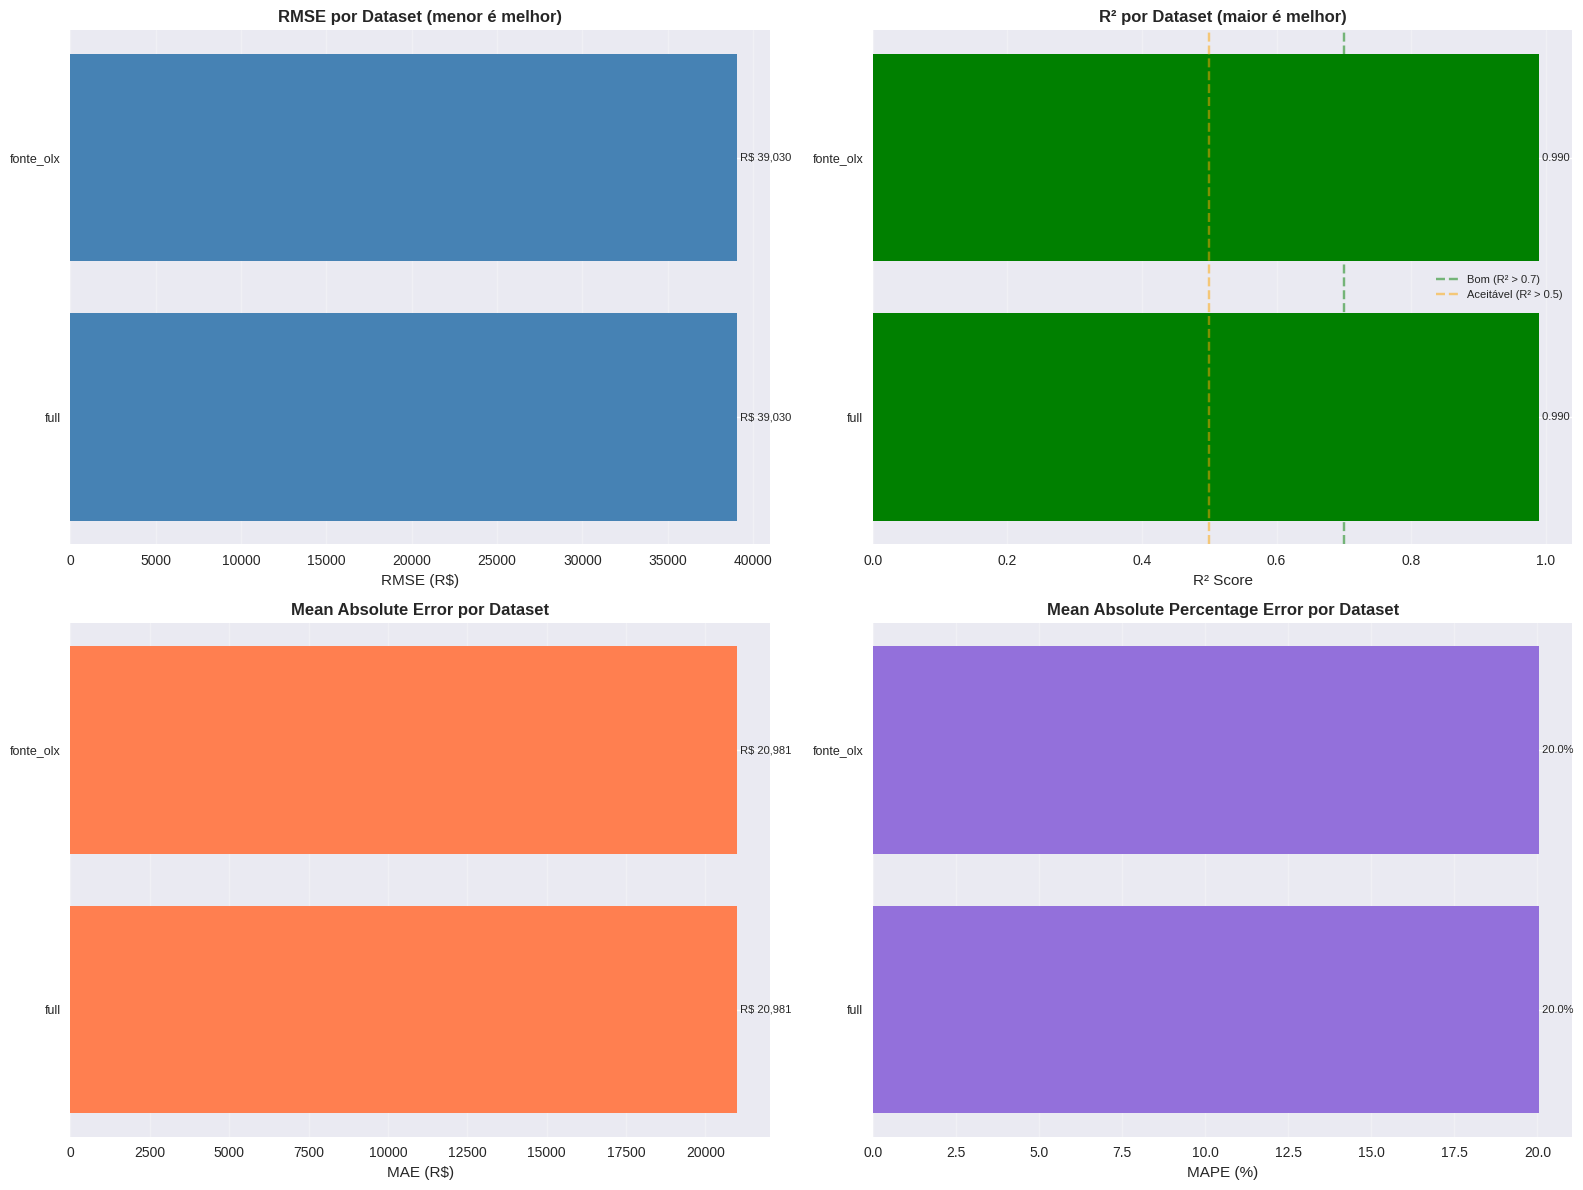

In [49]:
# Visualizações Comparativas - Métricas Principais

if not results_df.empty:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. RMSE por Dataset
    ax1 = axes[0, 0]
    sorted_df = results_df.sort_values('rmse_test')
    ax1.barh(range(len(sorted_df)), sorted_df['rmse_test'], color='steelblue')
    ax1.set_yticks(range(len(sorted_df)))
    ax1.set_yticklabels(sorted_df['dataset'], fontsize=9)
    ax1.set_xlabel('RMSE (R$)', fontsize=11)
    ax1.set_title('RMSE por Dataset (menor é melhor)', fontsize=12, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    for i, v in enumerate(sorted_df['rmse_test']):
        ax1.text(v, i, f' R$ {v:,.0f}', va='center', fontsize=8)

    # 2. R² por Dataset
    ax2 = axes[0, 1]
    sorted_df_r2 = results_df.sort_values('r2_test', ascending=False)
    colors = ['green' if r2 > 0.7 else 'orange' if r2 > 0.5 else 'red' for r2 in sorted_df_r2['r2_test']]
    ax2.barh(range(len(sorted_df_r2)), sorted_df_r2['r2_test'], color=colors)
    ax2.set_yticks(range(len(sorted_df_r2)))
    ax2.set_yticklabels(sorted_df_r2['dataset'], fontsize=9)
    ax2.set_xlabel('R² Score', fontsize=11)
    ax2.set_title('R² por Dataset (maior é melhor)', fontsize=12, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    ax2.axvline(x=0.7, color='green', linestyle='--', alpha=0.5, label='Bom (R² > 0.7)')
    ax2.axvline(x=0.5, color='orange', linestyle='--', alpha=0.5, label='Aceitável (R² > 0.5)')
    ax2.legend(fontsize=8)
    for i, v in enumerate(sorted_df_r2['r2_test']):
        ax2.text(v, i, f' {v:.3f}', va='center', fontsize=8)

    # 3. MAE por Dataset
    ax3 = axes[1, 0]
    sorted_df_mae = results_df.sort_values('mae_test')
    ax3.barh(range(len(sorted_df_mae)), sorted_df_mae['mae_test'], color='coral')
    ax3.set_yticks(range(len(sorted_df_mae)))
    ax3.set_yticklabels(sorted_df_mae['dataset'], fontsize=9)
    ax3.set_xlabel('MAE (R$)', fontsize=11)
    ax3.set_title('Mean Absolute Error por Dataset', fontsize=12, fontweight='bold')
    ax3.grid(axis='x', alpha=0.3)
    for i, v in enumerate(sorted_df_mae['mae_test']):
        ax3.text(v, i, f' R$ {v:,.0f}', va='center', fontsize=8)

    # 4. MAPE por Dataset
    ax4 = axes[1, 1]
    sorted_df_mape = results_df.sort_values('mape_test', na_position='last')
    valid_mape = sorted_df_mape['mape_test'].notna()
    if valid_mape.sum() > 0:
        ax4.barh(range(valid_mape.sum()), sorted_df_mape.loc[valid_mape, 'mape_test'], color='mediumpurple')
        ax4.set_yticks(range(valid_mape.sum()))
        ax4.set_yticklabels(sorted_df_mape.loc[valid_mape, 'dataset'], fontsize=9)
        ax4.set_xlabel('MAPE (%)', fontsize=11)
        ax4.set_title('Mean Absolute Percentage Error por Dataset', fontsize=12, fontweight='bold')
        ax4.grid(axis='x', alpha=0.3)
        for i, v in enumerate(sorted_df_mape.loc[valid_mape, 'mape_test']):
            ax4.text(v, i, f' {v:.1f}%', va='center', fontsize=8)
    else:
        ax4.text(0.5, 0.5, 'MAPE não disponível\n(valores zero no target)',
                ha='center', va='center', transform=ax4.transAxes, fontsize=10)
        ax4.set_title('Mean Absolute Percentage Error por Dataset', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

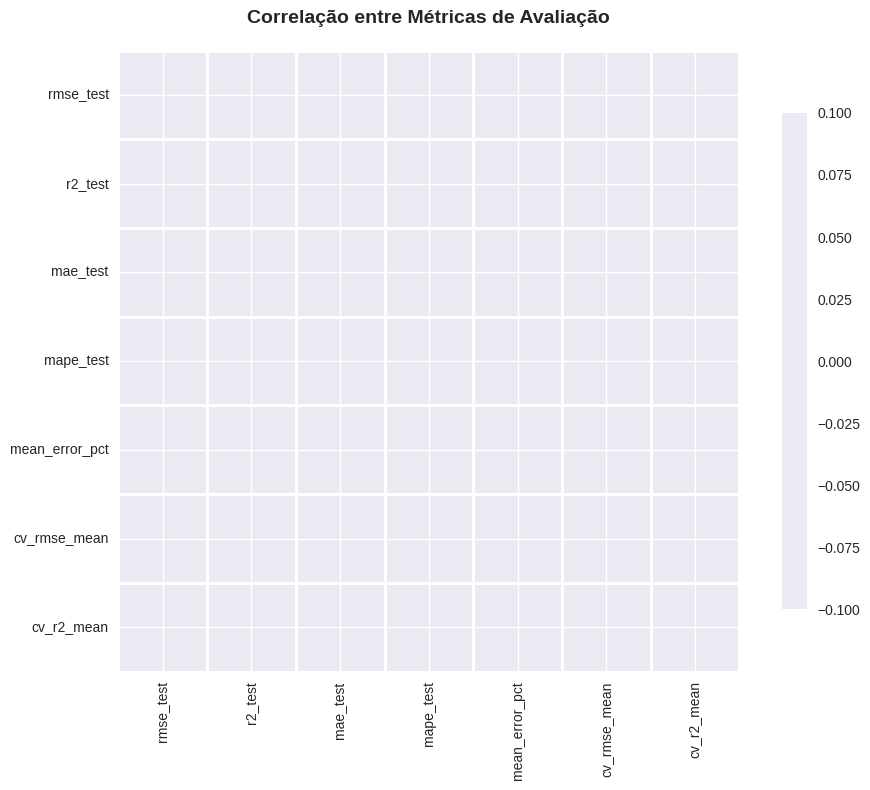

In [50]:
# Heatmap de Correlação entre Métricas

if not results_df.empty:
    # Seleciona métricas numéricas para correlação
    metric_cols = ['rmse_test', 'r2_test', 'mae_test', 'mape_test', 'mean_error_pct',
                   'cv_rmse_mean', 'cv_r2_mean']
    metric_cols = [c for c in metric_cols if c in results_df.columns]

    if len(metric_cols) > 1:
        corr_matrix = results_df[metric_cols].corr()

        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                   square=True, linewidths=1, cbar_kws={"shrink": 0.8})
        plt.title('Correlação entre Métricas de Avaliação', fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()
    else:
        print("Métricas insuficientes para gerar heatmap de correlação.")


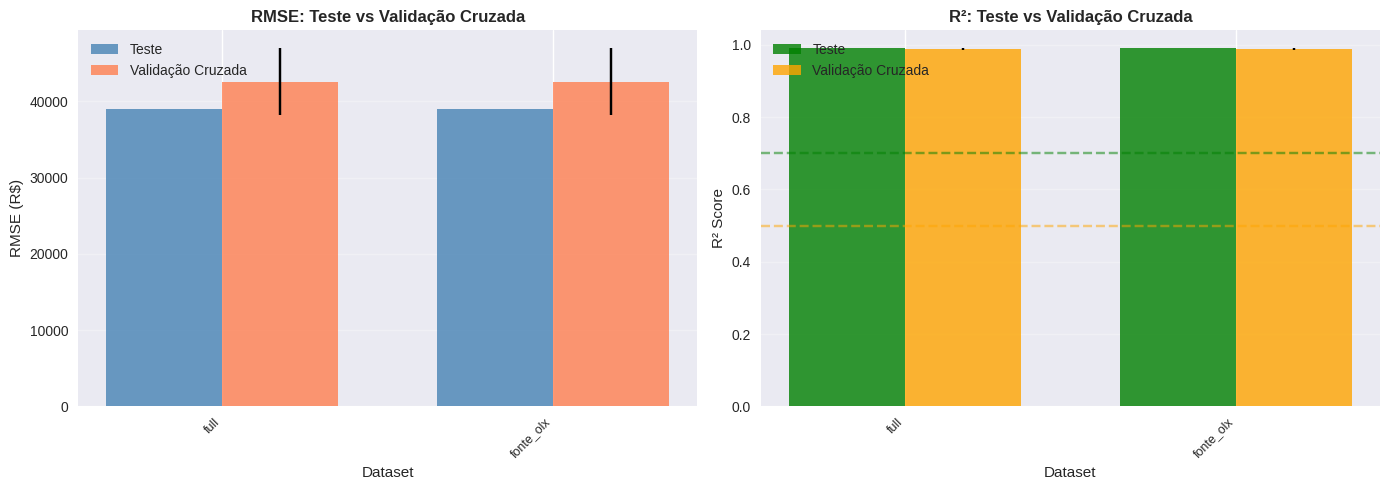

In [51]:
# Comparação Teste vs Validação Cruzada

if not results_df.empty and 'cv_rmse_mean' in results_df.columns:
    valid_cv = results_df['cv_rmse_mean'].notna()

    if valid_cv.sum() > 0:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        df_cv = results_df[valid_cv].copy()

        # RMSE: Teste vs CV
        ax1 = axes[0]
        x_pos = np.arange(len(df_cv))
        width = 0.35

        ax1.bar(x_pos - width/2, df_cv['rmse_test'], width, label='Teste', color='steelblue', alpha=0.8)
        ax1.bar(x_pos + width/2, df_cv['cv_rmse_mean'], width, label='Validação Cruzada',
               color='coral', alpha=0.8, yerr=df_cv['cv_rmse_std'], capsize=5)

        ax1.set_xlabel('Dataset', fontsize=11)
        ax1.set_ylabel('RMSE (R$)', fontsize=11)
        ax1.set_title('RMSE: Teste vs Validação Cruzada', fontsize=12, fontweight='bold')
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels(df_cv['dataset'], rotation=45, ha='right', fontsize=9)
        ax1.legend()
        ax1.grid(axis='y', alpha=0.3)

        # R²: Teste vs CV
        ax2 = axes[1]
        ax2.bar(x_pos - width/2, df_cv['r2_test'], width, label='Teste', color='green', alpha=0.8)
        ax2.bar(x_pos + width/2, df_cv['cv_r2_mean'], width, label='Validação Cruzada',
               color='orange', alpha=0.8, yerr=df_cv['cv_r2_std'], capsize=5)

        ax2.set_xlabel('Dataset', fontsize=11)
        ax2.set_ylabel('R² Score', fontsize=11)
        ax2.set_title('R²: Teste vs Validação Cruzada', fontsize=12, fontweight='bold')
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels(df_cv['dataset'], rotation=45, ha='right', fontsize=9)
        ax2.legend()
        ax2.grid(axis='y', alpha=0.3)
        ax2.axhline(y=0.7, color='green', linestyle='--', alpha=0.5)
        ax2.axhline(y=0.5, color='orange', linestyle='--', alpha=0.5)

        plt.tight_layout()
        plt.show()
    else:
        print("Validação cruzada não disponível para nenhum modelo.")


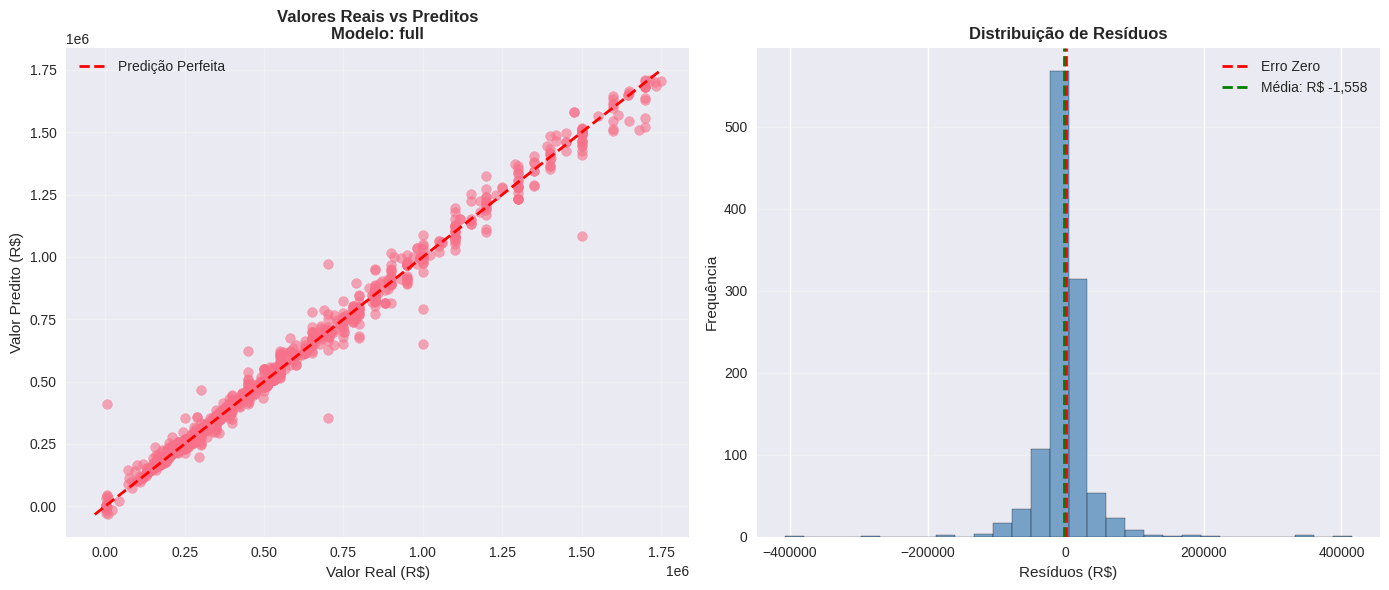

Modelo analisado: full
RMSE: R$ 39,029.81
R²: 0.9900
Média dos resíduos: R$ -1,558.29
Desvio padrão dos resíduos: R$ 39,015.80


In [52]:
# Gráfico de Dispersão: Valores Reais vs Preditos (Melhor Modelo)

if not results_df.empty and len(models_data) > 0:
    # Seleciona o melhor modelo baseado em RMSE (menor)
    best_model_name = results_df.loc[results_df['rmse_test'].idxmin(), 'dataset']
    best_model_data = models_data[best_model_name]

    y_test = best_model_data['y_test']
    y_pred = best_model_data['y_pred']

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Scatter plot
    ax1 = axes[0]
    ax1.scatter(y_test, y_pred, alpha=0.6, s=50)

    # Linha de referência (y = x)
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Predição Perfeita')

    ax1.set_xlabel('Valor Real (R$)', fontsize=11)
    ax1.set_ylabel('Valor Predito (R$)', fontsize=11)
    ax1.set_title(f'Valores Reais vs Preditos\nModelo: {best_model_name}',
                 fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # Histograma de resíduos
    ax2 = axes[1]
    residuals = y_test - y_pred
    ax2.hist(residuals, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    ax2.axvline(x=0, color='red', linestyle='--', lw=2, label='Erro Zero')
    ax2.axvline(x=residuals.mean(), color='green', linestyle='--', lw=2,
               label=f'Média: R$ {residuals.mean():,.0f}')
    ax2.set_xlabel('Resíduos (R$)', fontsize=11)
    ax2.set_ylabel('Frequência', fontsize=11)
    ax2.set_title('Distribuição de Resíduos', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    print(f"Modelo analisado: {best_model_name}")
    print(f"RMSE: R$ {best_model_data['rmse_test']:,.2f}")
    print(f"R²: {best_model_data['r2_test']:.4f}")
    print(f"Média dos resíduos: R$ {residuals.mean():,.2f}")
    print(f"Desvio padrão dos resíduos: R$ {residuals.std():,.2f}")


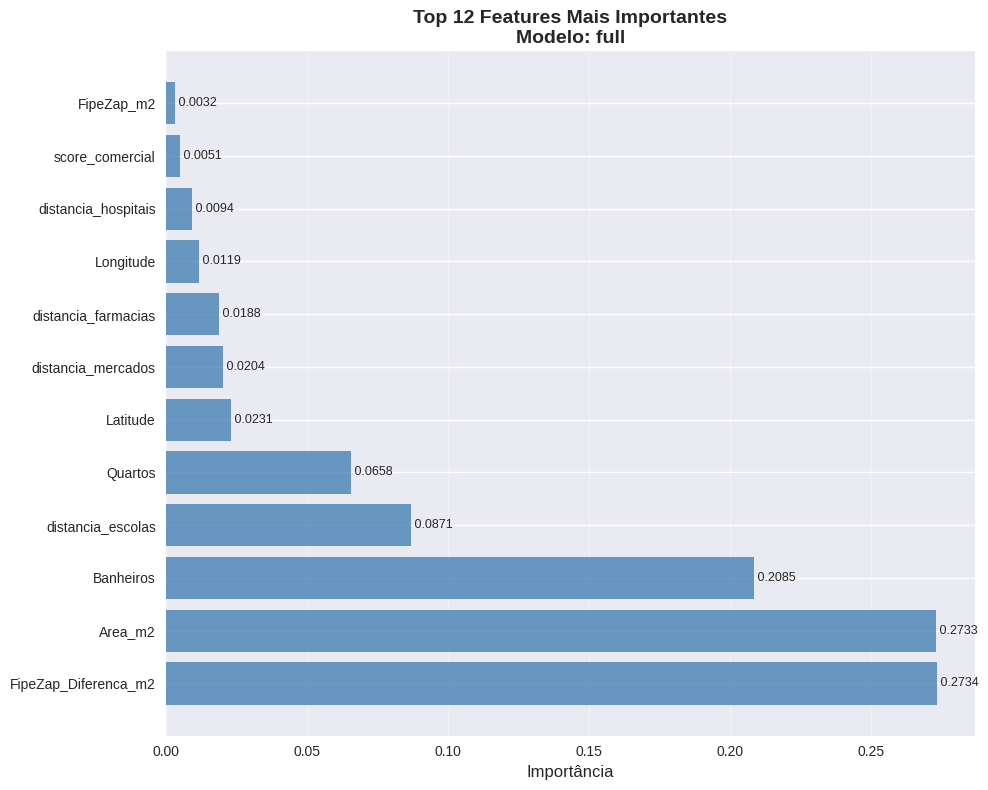


Top 12 Features do Modelo 'full':
             feature  importance
FipeZap_Diferenca_m2    0.273410
             Area_m2    0.273284
           Banheiros    0.208519
   distancia_escolas    0.087138
             Quartos    0.065801
            Latitude    0.023088
  distancia_mercados    0.020381
 distancia_farmacias    0.018798
           Longitude    0.011923
 distancia_hospitais    0.009384
     score_comercial    0.005099
          FipeZap_m2    0.003175


In [53]:
# Análise de Importância de Features (Top Features do Melhor Modelo)

if not results_df.empty and len(models_data) > 0:
    best_model_name = results_df.loc[results_df['rmse_test'].idxmin(), 'dataset']
    best_model_data = models_data[best_model_name]
    feature_importance = best_model_data['feature_importance']

    # Top 15 features
    top_n = min(15, len(feature_importance))
    top_features = feature_importance.head(top_n)

    fig, ax = plt.subplots(figsize=(10, 8))

    y_pos = np.arange(len(top_features))
    ax.barh(y_pos, top_features['importance'], color='steelblue', alpha=0.8)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(top_features['feature'], fontsize=10)
    ax.set_xlabel('Importância', fontsize=12)
    ax.set_title(f'Top {top_n} Features Mais Importantes\nModelo: {best_model_name}',
                fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

    # Adiciona valores nas barras
    for i, v in enumerate(top_features['importance']):
        ax.text(v, i, f' {v:.4f}', va='center', fontsize=9)

    plt.tight_layout()
    plt.show()

    print(f"\nTop {top_n} Features do Modelo '{best_model_name}':")
    print(top_features.to_string(index=False))


In [54]:
# Seleção do Melhor Modelo

if not results_df.empty and len(models_data) > 0:
    def select_best_model(results_df):
        """
        Seleciona o melhor modelo baseado em múltiplas métricas.
        Prioriza: RMSE (menor), R² (maior), e estabilidade (CV).
        """
        # Usa CV se disponível, senão usa teste
        if 'cv_rmse_mean' in results_df.columns:
            rmse_col = 'cv_rmse_mean'
            r2_col = 'cv_r2_mean'
        else:
            rmse_col = 'rmse_test'
            r2_col = 'r2_test'

        # Filtra modelos com métricas válidas
        valid_models = results_df[results_df[rmse_col].notna() & results_df[r2_col].notna()].copy()

        if valid_models.empty:
            return None

        # Normaliza métricas para scoring (0-1, maior é melhor)
        # RMSE: menor é melhor, então invertemos
        rmse_max = valid_models[rmse_col].max()
        rmse_min = valid_models[rmse_col].min()
        if rmse_max > rmse_min:
            valid_models['rmse_score'] = 1 - (valid_models[rmse_col] - rmse_min) / (rmse_max - rmse_min)
        else:
            valid_models['rmse_score'] = 1.0

        # R²: maior é melhor, normaliza para 0-1
        r2_max = valid_models[r2_col].max()
        r2_min = valid_models[r2_col].min()
        if r2_max > r2_min:
            valid_models['r2_score'] = (valid_models[r2_col] - r2_min) / (r2_max - r2_min)
        else:
            valid_models['r2_score'] = 1.0

        # Score combinado (pesos: 60% RMSE, 40% R²)
        valid_models['combined_score'] = 0.6 * valid_models['rmse_score'] + 0.4 * valid_models['r2_score']

        # Seleciona o modelo com maior score combinado
        best_idx = valid_models['combined_score'].idxmax()
        return valid_models.loc[best_idx, 'dataset']

    best_model_name = select_best_model(results_df)

    if best_model_name:
        best_model_data = models_data[best_model_name]
        best_metrics = results_df[results_df['dataset'] == best_model_name].iloc[0]

        print("="*70)
        print("MELHOR MODELO SELECIONADO")
        print("="*70)
        print(f"\nDataset: {best_model_name}")
        print(f"\nMétricas de Desempenho:")
        print(f"  RMSE (teste): R$ {best_metrics['rmse_test']:,.2f}")
        print(f"  R² (teste): {best_metrics['r2_test']:.4f}")
        print(f"  MAE (teste): R$ {best_metrics['mae_test']:,.2f}")
        if pd.notna(best_metrics.get('mape_test')):
            print(f"  MAPE (teste): {best_metrics['mape_test']:.2f}%")

        if pd.notna(best_metrics.get('cv_rmse_mean')):
            print(f"\nValidação Cruzada (5-fold):")
            print(f"  RMSE (CV): R$ {best_metrics['cv_rmse_mean']:,.2f} ± {best_metrics['cv_rmse_std']:,.2f}")
            print(f"  R² (CV): {best_metrics['cv_r2_mean']:.4f} ± {best_metrics['cv_r2_std']:.4f}")

        print(f"\nCaracterísticas do Modelo:")
        print(f"  Número de amostras: {best_metrics['n_samples']}")
        print(f"  Número de features: {best_metrics['n_features']}")
        print(f"  Features: {', '.join(best_model_data['feature_names'][:10])}...")

    else:
        print("Não foi possível selecionar o melhor modelo.")
        best_model_name = None
else:
    best_model_name = None
    print("Nenhum modelo disponível para seleção.")


MELHOR MODELO SELECIONADO

Dataset: full

Métricas de Desempenho:
  RMSE (teste): R$ 39,029.81
  R² (teste): 0.9900
  MAE (teste): R$ 20,980.97
  MAPE (teste): 20.05%

Validação Cruzada (5-fold):
  RMSE (CV): R$ 42,617.45 ± 4,370.27
  R² (CV): 0.9873 ± 0.0029

Características do Modelo:
  Número de amostras: 5697
  Número de features: 12
  Features: Area_m2, Quartos, Banheiros, Latitude, Longitude, distancia_farmacias, distancia_escolas, distancia_mercados, distancia_hospitais, score_comercial...


In [55]:
# Salvamento do Melhor Modelo

if best_model_name and best_model_name in models_data:
    best_model_data = models_data[best_model_name]
    best_model = best_model_data['model']

    # Salva o modelo
    model_file = BEST_MODEL_DIR / f"melhor_modelo_{best_model_name}.joblib"
    joblib.dump(best_model, model_file)
    print(f"\n✓ Modelo salvo em: {model_file}")

    # Salva também como modelo padrão (para compatibilidade com sistema)
    default_model_file = BEST_MODEL_DIR / "modelo_definitivo.joblib"
    joblib.dump(best_model, default_model_file)
    print(f"✓ Modelo padrão salvo em: {default_model_file}")

    # Salva informações do modelo
    model_info = {
        'dataset_origem': best_model_name,
        'timestamp': datetime.now().isoformat(),
        'n_samples': best_model_data['n_samples'],
        'n_features': best_model_data['n_features'],
        'feature_names': best_model_data['feature_names'],
        'rmse_test': float(best_model_data['rmse_test']),
        'r2_test': float(best_model_data['r2_test']),
        'mae_test': float(best_model_data['mae_test']),
        'mape_test': float(best_model_data['mape_test']) if pd.notna(best_model_data['mape_test']) else None,
        'cv_rmse_mean': float(best_model_data['cv_rmse_mean']) if best_model_data['cv_rmse_mean'] is not None else None,
        'cv_rmse_std': float(best_model_data['cv_rmse_std']) if best_model_data['cv_rmse_std'] is not None else None,
        'cv_r2_mean': float(best_model_data['cv_r2_mean']) if best_model_data['cv_r2_mean'] is not None else None,
        'cv_r2_std': float(best_model_data['cv_r2_std']) if best_model_data['cv_r2_std'] is not None else None,
    }

    import json
    info_file = BEST_MODEL_DIR / f"info_modelo_{best_model_name}.json"
    with open(info_file, 'w', encoding='utf-8') as f:
        json.dump(model_info, f, indent=2, ensure_ascii=False)
    print(f"✓ Informações do modelo salvas em: {info_file}")

    # Salva feature importance
    importance_file = BEST_MODEL_DIR / f"feature_importance_{best_model_name}.csv"
    best_model_data['feature_importance'].to_csv(importance_file, index=False)
    print(f"✓ Importância de features salva em: {importance_file}")

else:
    print("Nenhum modelo disponível para salvar.")



✓ Modelo salvo em: /content/dados_imoveis_teresina/modelos/melhor_modelo_full.joblib
✓ Modelo padrão salvo em: /content/dados_imoveis_teresina/modelos/modelo_definitivo.joblib
✓ Informações do modelo salvas em: /content/dados_imoveis_teresina/modelos/info_modelo_full.json
✓ Importância de features salva em: /content/dados_imoveis_teresina/modelos/feature_importance_full.csv


In [56]:
# Relatório Final Comparativo

if not results_df.empty:
    print("="*70)
    print("RELATÓRIO FINAL - COMPARAÇÃO DE MODELOS")
    print("="*70)

    print("\n📊 RESUMO EXECUTIVO")
    print("-"*70)
    print(f"Total de modelos treinados: {len(results_df)}")
    print(f"Modelos com validação cruzada: {results_df['cv_rmse_mean'].notna().sum()}")

    if best_model_name:
        print(f"\n🏆 MODELO SELECIONADO: {best_model_name}")
        best_row = results_df[results_df['dataset'] == best_model_name].iloc[0]
        print(f"   RMSE: R$ {best_row['rmse_test']:,.2f}")
        print(f"   R²: {best_row['r2_test']:.4f}")
        if pd.notna(best_row.get('cv_rmse_mean')):
            print(f"   RMSE (CV): R$ {best_row['cv_rmse_mean']:,.2f} ± {best_row['cv_rmse_std']:,.2f}")

    print("\n📈 RANKING DE MODELOS (por RMSE - menor é melhor)")
    print("-"*70)
    ranking = results_df.sort_values('rmse_test').copy()
    for idx, (_, row) in enumerate(ranking.iterrows(), 1):
        marker = "🏆" if row['dataset'] == best_model_name else f"{idx}."
        print(f"{marker} {row['dataset']:30s} | RMSE: R$ {row['rmse_test']:>10,.2f} | R²: {row['r2_test']:>6.4f}")

    print("\n📋 TABELA COMPARATIVA COMPLETA")
    print("-"*70)
    display_cols = ['dataset', 'n_samples', 'rmse_test', 'r2_test', 'mae_test']
    if 'cv_rmse_mean' in results_df.columns:
        display_cols.extend(['cv_rmse_mean', 'cv_r2_mean'])
    display_cols = [c for c in display_cols if c in results_df.columns]
    display(results_df[display_cols].sort_values('rmse_test').round(2))

    print("\n💡 RECOMENDAÇÕES")
    print("-"*70)
    if best_model_name:
        best_row = results_df[results_df['dataset'] == best_model_name].iloc[0]

        if best_row['r2_test'] > 0.7:
            print("✓ Modelo selecionado apresenta excelente poder preditivo (R² > 0.7)")
        elif best_row['r2_test'] > 0.5:
            print("⚠ Modelo selecionado apresenta poder preditivo aceitável (R² > 0.5)")
        else:
            print("⚠ Modelo selecionado apresenta poder preditivo baixo (R² < 0.5)")
            print("  Considere coletar mais dados ou ajustar features.")

        if pd.notna(best_row.get('cv_rmse_mean')):
            cv_std_pct = (best_row['cv_rmse_std'] / best_row['cv_rmse_mean']) * 100
            if cv_std_pct < 10:
                print("✓ Modelo apresenta boa estabilidade (baixa variância em CV)")
            else:
                print("⚠ Modelo apresenta variabilidade moderada em validação cruzada")

        print(f"\n✓ Modelo '{best_model_name}' salvo e pronto para uso no sistema.")
        print(f"  Localização: {BEST_MODEL_DIR / 'modelo_definitivo.joblib'}")

    print("\n" + "="*70)
    print("Análise concluída!")
    print("="*70)
else:
    print("Nenhum modelo foi treinado. Execute as células anteriores primeiro.")


RELATÓRIO FINAL - COMPARAÇÃO DE MODELOS

📊 RESUMO EXECUTIVO
----------------------------------------------------------------------
Total de modelos treinados: 2
Modelos com validação cruzada: 2

🏆 MODELO SELECIONADO: full
   RMSE: R$ 39,029.81
   R²: 0.9900
   RMSE (CV): R$ 42,617.45 ± 4,370.27

📈 RANKING DE MODELOS (por RMSE - menor é melhor)
----------------------------------------------------------------------
🏆 full                           | RMSE: R$  39,029.81 | R²: 0.9900
2. fonte_olx                      | RMSE: R$  39,029.81 | R²: 0.9900

📋 TABELA COMPARATIVA COMPLETA
----------------------------------------------------------------------


,dataset,n_samples,rmse_test,r2_test,mae_test,cv_rmse_mean,cv_r2_mean
0,full,5697,39029.81,0.99,20980.97,42617.45,0.99
1,fonte_olx,5697,39029.81,0.99,20980.97,42617.45,0.99



💡 RECOMENDAÇÕES
----------------------------------------------------------------------
✓ Modelo selecionado apresenta excelente poder preditivo (R² > 0.7)
⚠ Modelo apresenta variabilidade moderada em validação cruzada

✓ Modelo 'full' salvo e pronto para uso no sistema.
  Localização: /content/dados_imoveis_teresina/modelos/modelo_definitivo.joblib

Análise concluída!


ANÁLISE POR FAIXA DE VALOR - Melhor Modelo

📊 Métricas por Faixa de Preço:
--------------------------------------------------------------------------------


,faixa,min_valor,max_valor,n_samples,rmse,mae,medae,r2,mape,mean_error_pct,accuracy_10pct,accuracy_20pct,accuracy_30pct
0,Q1 (0-25%),1000.0,260000.0,277,30677.52,13280.75,7474.00,0.77,71.12,71.12,78.70,87.73,90.25
1,Q2 (25-50%),260000.0,420000.0,292,20559.71,12814.98,9438.33,0.77,3.86,3.86,92.12,98.63,99.32
2,Q3 (50-75%),420000.0,765000.0,286,39512.94,22261.61,14194.72,0.85,3.89,3.89,92.31,98.95,98.95
3,Q4 (75-100%),765000.0,1750000.0,284,56422.40,35520.54,21833.12,0.96,3.21,3.21,95.77,98.94,99.65


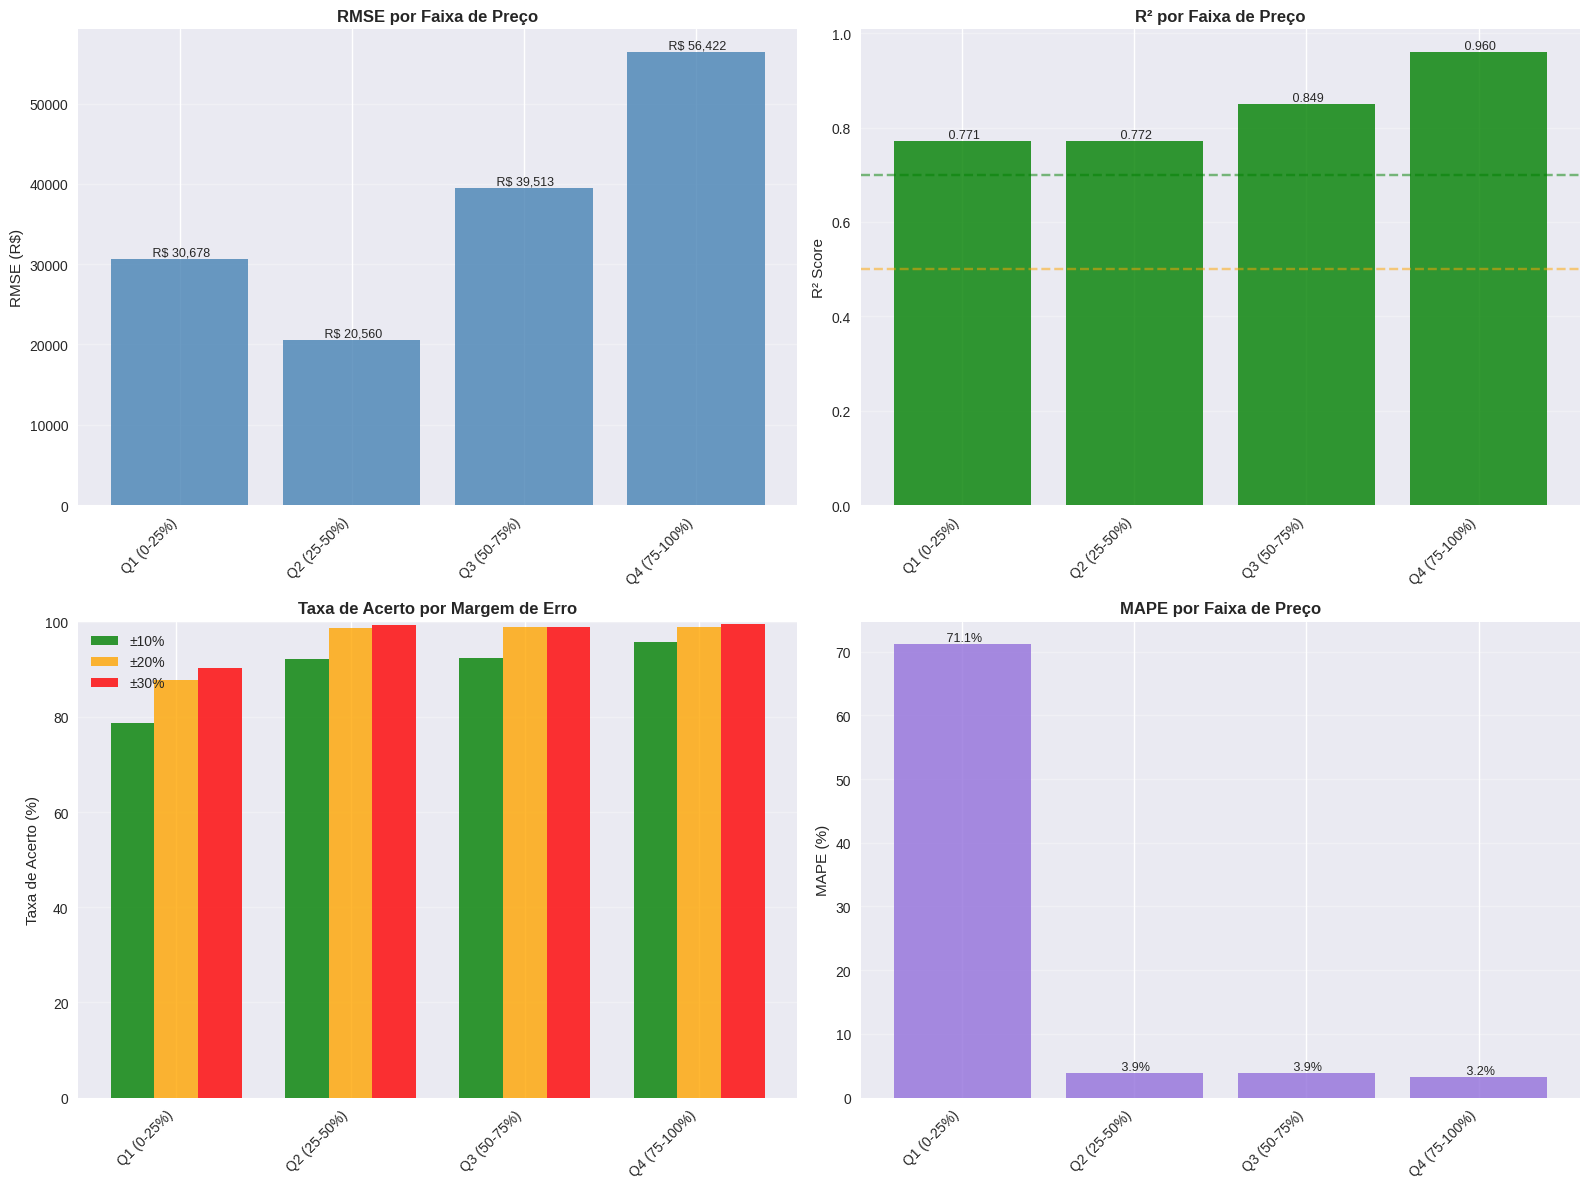


✓ Análise por faixa salva em: /content/dados_imoveis_teresina/modelos/analise_faixas_full.csv


In [57]:
# ============================================================================
# ANÁLISE AVANÇADA: Métricas por Faixa de Valor
# ============================================================================
# Similar à análise de métricas por classe no classificador,
# aqui analisamos o desempenho por faixas de preço

def analyze_by_price_range(y_test, y_pred, price_ranges=None):
    """
    Analisa métricas por faixa de preço (similar a métricas por classe no classificador).

    Args:
        y_test: Valores reais
        y_pred: Valores preditos
        price_ranges: Lista de tuplas (min, max) para faixas. Se None, cria automaticamente.

    Returns:
        DataFrame com métricas por faixa
    """
    if price_ranges is None:
        # Cria faixas automaticamente baseadas nos quartis
        q0 = y_test.min()
        q25 = y_test.quantile(0.25)
        q50 = y_test.quantile(0.50)
        q75 = y_test.quantile(0.75)
        q100 = y_test.max()

        price_ranges = [
            (q0, q25, "Q1 (0-25%)"),
            (q25, q50, "Q2 (25-50%)"),
            (q50, q75, "Q3 (50-75%)"),
            (q75, q100, "Q4 (75-100%)")
        ]

    results = []
    for range_info in price_ranges:
        if len(range_info) == 3:
            min_price, max_price, label = range_info
        else:
            min_price, max_price = range_info
            label = f"R$ {min_price:,.0f} - R$ {max_price:,.0f}"

        mask = (y_test >= min_price) & (y_test < max_price)
        if mask.sum() > 0:
            y_true_range = y_test[mask]
            y_pred_range = y_pred[mask]

            rmse = np.sqrt(mean_squared_error(y_true_range, y_pred_range))
            mae = mean_absolute_error(y_true_range, y_pred_range)
            medae = median_absolute_error(y_true_range, y_pred_range)
            r2 = r2_score(y_true_range, y_pred_range)

            # MAPE
            mask_nonzero = y_true_range != 0
            if mask_nonzero.sum() > 0:
                mape = mean_absolute_percentage_error(
                    y_true_range[mask_nonzero],
                    y_pred_range[mask_nonzero]
                ) * 100
            else:
                mape = np.nan

            # Erro percentual médio
            error_pct = np.abs((y_true_range - y_pred_range) / y_true_range) * 100
            mean_error_pct = error_pct[mask_nonzero].mean() if mask_nonzero.sum() > 0 else np.nan

            # Taxas de acerto dentro de margens
            accuracy_10pct = (error_pct[mask_nonzero] <= 10).mean() * 100 if mask_nonzero.sum() > 0 else 0
            accuracy_20pct = (error_pct[mask_nonzero] <= 20).mean() * 100 if mask_nonzero.sum() > 0 else 0
            accuracy_30pct = (error_pct[mask_nonzero] <= 30).mean() * 100 if mask_nonzero.sum() > 0 else 0

            results.append({
                'faixa': label,
                'min_valor': min_price,
                'max_valor': max_price,
                'n_samples': int(mask.sum()),
                'rmse': float(rmse),
                'mae': float(mae),
                'medae': float(medae),
                'r2': float(r2),
                'mape': float(mape) if not np.isnan(mape) else np.nan,
                'mean_error_pct': float(mean_error_pct) if not np.isnan(mean_error_pct) else np.nan,
                'accuracy_10pct': float(accuracy_10pct),
                'accuracy_20pct': float(accuracy_20pct),
                'accuracy_30pct': float(accuracy_30pct),
            })

    return pd.DataFrame(results)

# Aplicar análise por faixa no melhor modelo
if not results_df.empty and len(models_data) > 0:
    try:
        best_model_name = results_df.loc[results_df['rmse_test'].idxmin(), 'dataset']
    except:
        best_model_name = None

    if best_model_name and best_model_name in models_data:
        best_model_data = models_data[best_model_name]
        y_test = best_model_data['y_test']
        y_pred = best_model_data['y_pred']

        print("="*80)
        print("ANÁLISE POR FAIXA DE VALOR - Melhor Modelo")
        print("="*80)

        price_range_analysis = analyze_by_price_range(y_test, y_pred)

        print("\n📊 Métricas por Faixa de Preço:")
        print("-"*80)
        display(price_range_analysis.round(2))

        # Visualização
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # 1. RMSE por faixa
        ax1 = axes[0, 0]
        ax1.bar(range(len(price_range_analysis)), price_range_analysis['rmse'],
               color='steelblue', alpha=0.8)
        ax1.set_xticks(range(len(price_range_analysis)))
        ax1.set_xticklabels(price_range_analysis['faixa'], rotation=45, ha='right')
        ax1.set_ylabel('RMSE (R$)', fontsize=11)
        ax1.set_title('RMSE por Faixa de Preço', fontsize=12, fontweight='bold')
        ax1.grid(axis='y', alpha=0.3)
        for i, v in enumerate(price_range_analysis['rmse']):
            ax1.text(i, v, f' R$ {v:,.0f}', ha='center', va='bottom', fontsize=9)

        # 2. R² por faixa
        ax2 = axes[0, 1]
        colors = ['green' if r2 > 0.7 else 'orange' if r2 > 0.5 else 'red'
                 for r2 in price_range_analysis['r2']]
        ax2.bar(range(len(price_range_analysis)), price_range_analysis['r2'],
               color=colors, alpha=0.8)
        ax2.set_xticks(range(len(price_range_analysis)))
        ax2.set_xticklabels(price_range_analysis['faixa'], rotation=45, ha='right')
        ax2.set_ylabel('R² Score', fontsize=11)
        ax2.set_title('R² por Faixa de Preço', fontsize=12, fontweight='bold')
        ax2.grid(axis='y', alpha=0.3)
        ax2.axhline(y=0.7, color='green', linestyle='--', alpha=0.5)
        ax2.axhline(y=0.5, color='orange', linestyle='--', alpha=0.5)
        for i, v in enumerate(price_range_analysis['r2']):
            ax2.text(i, v, f' {v:.3f}', ha='center', va='bottom', fontsize=9)

        # 3. Taxa de acerto por margem
        ax3 = axes[1, 0]
        x = np.arange(len(price_range_analysis))
        width = 0.25
        ax3.bar(x - width, price_range_analysis['accuracy_10pct'], width,
               label='±10%', color='green', alpha=0.8)
        ax3.bar(x, price_range_analysis['accuracy_20pct'], width,
               label='±20%', color='orange', alpha=0.8)
        ax3.bar(x + width, price_range_analysis['accuracy_30pct'], width,
               label='±30%', color='red', alpha=0.8)
        ax3.set_xticks(x)
        ax3.set_xticklabels(price_range_analysis['faixa'], rotation=45, ha='right')
        ax3.set_ylabel('Taxa de Acerto (%)', fontsize=11)
        ax3.set_title('Taxa de Acerto por Margem de Erro', fontsize=12, fontweight='bold')
        ax3.legend()
        ax3.grid(axis='y', alpha=0.3)
        ax3.set_ylim([0, 100])

        # 4. MAPE por faixa
        ax4 = axes[1, 1]
        valid_mape = price_range_analysis['mape'].notna()
        if valid_mape.sum() > 0:
            ax4.bar(range(valid_mape.sum()),
                   price_range_analysis.loc[valid_mape, 'mape'],
                   color='mediumpurple', alpha=0.8)
            ax4.set_xticks(range(valid_mape.sum()))
            ax4.set_xticklabels(price_range_analysis.loc[valid_mape, 'faixa'],
                              rotation=45, ha='right')
            ax4.set_ylabel('MAPE (%)', fontsize=11)
            ax4.set_title('MAPE por Faixa de Preço', fontsize=12, fontweight='bold')
            ax4.grid(axis='y', alpha=0.3)
            for i, v in enumerate(price_range_analysis.loc[valid_mape, 'mape']):
                ax4.text(i, v, f' {v:.1f}%', ha='center', va='bottom', fontsize=9)
        else:
            ax4.text(0.5, 0.5, 'MAPE não disponível',
                    ha='center', va='center', transform=ax4.transAxes, fontsize=12)
            ax4.set_title('MAPE por Faixa de Preço', fontsize=12, fontweight='bold')

        plt.tight_layout()
        plt.show()

        # Salvar análise
        price_range_file = BEST_MODEL_DIR / f"analise_faixas_{best_model_name}.csv"
        price_range_analysis.to_csv(price_range_file, index=False)
        print(f"\n✓ Análise por faixa salva em: {price_range_file}")
    else:
        print("Melhor modelo não disponível para análise por faixa.")
else:
    print("Execute as células anteriores primeiro para gerar a análise por faixa.")


In [58]:
# ============================================================================
# ANÁLISE DETALHADA DE ERROS
# ============================================================================
# Similar à análise de erros do classificador, identifica casos problemáticos

def detailed_error_analysis(y_test, y_pred, X_test=None, feature_names=None):
    """
    Análise detalhada de erros (similar à análise de erros do classificador).

    Args:
        y_test: Valores reais
        y_pred: Valores preditos
        X_test: Features do conjunto de teste (opcional)
        feature_names: Nomes das features (opcional)

    Returns:
        Dicionário com análise detalhada
    """
    errors = np.abs(y_test - y_pred)
    error_pct = np.abs((y_test - y_pred) / y_test) * 100
    residuals = y_test - y_pred

    # Identificar outliers usando IQR
    q1, q3 = errors.quantile([0.25, 0.75])
    iqr = q3 - q1
    outlier_threshold = q3 + 1.5 * iqr
    outliers_mask = errors > outlier_threshold

    # Top erros absolutos
    top_errors_idx = errors.nlargest(10).index.tolist()

    # Top erros percentuais
    mask_nonzero = y_test != 0
    if mask_nonzero.sum() > 0:
        top_pct_errors_idx = error_pct[mask_nonzero].nlargest(10).index.tolist()
    else:
        top_pct_errors_idx = []

    # Estatísticas de erro
    error_stats = {
        'mean': float(errors.mean()),
        'median': float(errors.median()),
        'std': float(errors.std()),
        'q25': float(errors.quantile(0.25)),
        'q50': float(errors.quantile(0.50)),
        'q75': float(errors.quantile(0.75)),
        'q95': float(errors.quantile(0.95)),
        'q99': float(errors.quantile(0.99)),
        'max': float(errors.max()),
    }

    # Estatísticas de erro percentual
    if mask_nonzero.sum() > 0:
        error_pct_stats = {
            'mean': float(error_pct[mask_nonzero].mean()),
            'median': float(error_pct[mask_nonzero].median()),
            'std': float(error_pct[mask_nonzero].std()),
            'q95': float(error_pct[mask_nonzero].quantile(0.95)),
            'q99': float(error_pct[mask_nonzero].quantile(0.99)),
            'max': float(error_pct[mask_nonzero].max()),
        }
    else:
        error_pct_stats = None

    # Análise de resíduos
    residual_stats = {
        'mean': float(residuals.mean()),
        'median': float(residuals.median()),
        'std': float(residuals.std()),
        'skewness': float(residuals.skew()),
        'kurtosis': float(residuals.kurtosis()),
    }

    return {
        'top_absolute_errors_idx': top_errors_idx,
        'top_percentage_errors_idx': top_pct_errors_idx,
        'outliers_mask': outliers_mask,
        'n_outliers': int(outliers_mask.sum()),
        'outlier_percentage': float(outliers_mask.sum() / len(y_test) * 100),
        'error_stats': error_stats,
        'error_pct_stats': error_pct_stats,
        'residual_stats': residual_stats,
        'errors_df': pd.DataFrame({
            'valor_real': y_test.values,
            'valor_predito': y_pred.values,
            'erro_absoluto': errors.values,
            'erro_percentual': error_pct.values if mask_nonzero.sum() > 0 else np.full(len(y_test), np.nan),
            'residual': residuals.values,
            'eh_outlier': outliers_mask.values
        })
    }

# Aplicar análise de erros no melhor modelo
if not results_df.empty and len(models_data) > 0:
    try:
        best_model_name = results_df.loc[results_df['rmse_test'].idxmin(), 'dataset']
    except:
        best_model_name = None

    if best_model_name and best_model_name in models_data:
        best_model_data = models_data[best_model_name]
        y_test = best_model_data['y_test']
        y_pred = best_model_data['y_pred']
        X_test = best_model_data['X_test']
        feature_names = best_model_data['feature_names']

        print("="*80)
        print("ANÁLISE DETALHADA DE ERROS - Melhor Modelo")
        print("="*80)

        error_analysis = detailed_error_analysis(y_test, y_pred, X_test, feature_names)

        print("\n📊 Estatísticas de Erro:")
        print("-"*80)
        print(f"Erro Absoluto Médio: R$ {error_analysis['error_stats']['mean']:,.2f}")
        print(f"Erro Absoluto Mediano: R$ {error_analysis['error_stats']['median']:,.2f}")
        print(f"Desvio Padrão: R$ {error_analysis['error_stats']['std']:,.2f}")
        print(f"Percentil 95: R$ {error_analysis['error_stats']['q95']:,.2f}")
        print(f"Percentil 99: R$ {error_analysis['error_stats']['q99']:,.2f}")
        print(f"Erro Máximo: R$ {error_analysis['error_stats']['max']:,.2f}")

        if error_analysis['error_pct_stats']:
            print(f"\nErro Percentual Médio: {error_analysis['error_pct_stats']['mean']:.2f}%")
            print(f"Erro Percentual Mediano: {error_analysis['error_pct_stats']['median']:.2f}%")
            print(f"Erro Percentual Máximo: {error_analysis['error_pct_stats']['max']:.2f}%")

        print(f"\n🔍 Análise de Outliers:")
        print(f"   Total de outliers: {error_analysis['n_outliers']} ({error_analysis['outlier_percentage']:.2f}%)")

        print(f"\n📈 Estatísticas de Resíduos:")
        print(f"   Média: R$ {error_analysis['residual_stats']['mean']:,.2f}")
        print(f"   Mediana: R$ {error_analysis['residual_stats']['median']:,.2f}")
        print(f"   Desvio Padrão: R$ {error_analysis['residual_stats']['std']:,.2f}")
        print(f"   Assimetria: {error_analysis['residual_stats']['skewness']:.3f}")
        print(f"   Curtose: {error_analysis['residual_stats']['kurtosis']:.3f}")

        # Visualização de erros
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # 1. Distribuição de erros absolutos
        ax1 = axes[0, 0]
        ax1.hist(error_analysis['errors_df']['erro_absoluto'], bins=50,
                  edgecolor='black', alpha=0.7, color='steelblue')
        ax1.axvline(error_analysis['error_stats']['mean'], color='red',
                   linestyle='--', lw=2, label=f'Média: R$ {error_analysis["error_stats"]["mean"]:,.0f}')
        ax1.axvline(error_analysis['error_stats']['median'], color='green',
                   linestyle='--', lw=2, label=f'Mediana: R$ {error_analysis["error_stats"]["median"]:,.0f}')
        ax1.set_xlabel('Erro Absoluto (R$)', fontsize=11)
        ax1.set_ylabel('Frequência', fontsize=11)
        ax1.set_title('Distribuição de Erros Absolutos', fontsize=12, fontweight='bold')
        ax1.legend()
        ax1.grid(alpha=0.3, axis='y')

        # 2. Distribuição de erros percentuais
        ax2 = axes[0, 1]
        valid_pct = error_analysis['errors_df']['erro_percentual'].notna()
        if valid_pct.sum() > 0:
            ax2.hist(error_analysis['errors_df'].loc[valid_pct, 'erro_percentual'],
                    bins=50, edgecolor='black', alpha=0.7, color='coral')
            if error_analysis['error_pct_stats']:
                ax2.axvline(error_analysis['error_pct_stats']['mean'], color='red',
                           linestyle='--', lw=2,
                           label=f'Média: {error_analysis["error_pct_stats"]["mean"]:.1f}%')
                ax2.axvline(error_analysis['error_pct_stats']['median'], color='green',
                           linestyle='--', lw=2,
                           label=f'Mediana: {error_analysis["error_pct_stats"]["median"]:.1f}%')
            ax2.set_xlabel('Erro Percentual (%)', fontsize=11)
            ax2.set_ylabel('Frequência', fontsize=11)
            ax2.set_title('Distribuição de Erros Percentuais', fontsize=12, fontweight='bold')
            ax2.legend()
            ax2.grid(alpha=0.3, axis='y')
        else:
            ax2.text(0.5, 0.5, 'Erros percentuais não disponíveis',
                    ha='center', va='center', transform=ax2.transAxes, fontsize=12)
            ax2.set_title('Distribuição de Erros Percentuais', fontsize=12, fontweight='bold')

        # 3. Q-Q Plot de resíduos
        ax3 = axes[1, 0]
        from scipy import stats
        residuals = error_analysis['errors_df']['residual']
        stats.probplot(residuals, dist="norm", plot=ax3)
        ax3.set_title('Q-Q Plot dos Resíduos\n(Normalidade)', fontsize=12, fontweight='bold')
        ax3.grid(alpha=0.3)

        # 4. Resíduos vs Valores Preditos
        ax4 = axes[1, 1]
        ax4.scatter(y_pred, error_analysis['errors_df']['residual'],
                   alpha=0.6, s=30, color='steelblue')
        ax4.axhline(y=0, color='red', linestyle='--', lw=2)
        ax4.set_xlabel('Valor Predito (R$)', fontsize=11)
        ax4.set_ylabel('Resíduo (R$)', fontsize=11)
        ax4.set_title('Resíduos vs Valores Preditos\n(Homocedasticidade)',
                     fontsize=12, fontweight='bold')
        ax4.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Exemplos de casos com maior erro
        print("\n🔴 TOP 5 CASOS COM MAIOR ERRO ABSOLUTO:")
        print("-"*80)
        top_errors_df = error_analysis['errors_df'].loc[error_analysis['top_absolute_errors_idx']].copy()
        top_errors_df = top_errors_df.sort_values('erro_absoluto', ascending=False)
        for idx, (i, row) in enumerate(top_errors_df.head(5).iterrows(), 1):
            print(f"\n{idx}. Erro: R$ {row['erro_absoluto']:,.2f}")
            print(f"   Valor Real: R$ {row['valor_real']:,.2f}")
            print(f"   Valor Predito: R$ {row['valor_predito']:,.2f}")
            if not np.isnan(row['erro_percentual']):
                print(f"   Erro Percentual: {row['erro_percentual']:.2f}%")

        # Salvar análise
        error_analysis_file = BEST_MODEL_DIR / f"analise_erros_{best_model_name}.csv"
        error_analysis['errors_df'].to_csv(error_analysis_file, index=False)
        print(f"\n✓ Análise de erros salva em: {error_analysis_file}")
    else:
        print("Melhor modelo não disponível para análise de erros.")
else:
    print("Execute as células anteriores primeiro para gerar a análise de erros.")


ANÁLISE DETALHADA DE ERROS - Melhor Modelo


AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [62]:
# ============================================================================
# MÉTRICAS ADICIONAIS E TAXAS DE ACERTO
# ============================================================================

def additional_regression_metrics(y_test, y_pred):
    """
    Calcula métricas adicionais úteis para regressão.
    Similar às métricas de confiança do classificador.
    """
    errors = np.abs(y_test - y_pred)
    error_pct = np.abs((y_test - y_pred) / y_test) * 100
    mask_nonzero = y_test != 0

    metrics = {
        'medae': float(median_absolute_error(y_test, y_pred)),
        'rmse': float(np.sqrt(mean_squared_error(y_test, y_pred))),
        'mae': float(mean_absolute_error(y_test, y_pred)),
        'r2': float(r2_score(y_test, y_pred)),
    }

    if mask_nonzero.sum() > 0:
        error_pct_valid = error_pct[mask_nonzero]
        metrics.update({
            'mape': float(mean_absolute_percentage_error(y_test[mask_nonzero], y_pred[mask_nonzero]) * 100),
            'error_pct_q25': float(error_pct_valid.quantile(0.25)),
            'error_pct_q50': float(error_pct_valid.quantile(0.50)),
            'error_pct_q75': float(error_pct_valid.quantile(0.75)),
            'error_pct_q95': float(error_pct_valid.quantile(0.95)),
            'error_pct_q99': float(error_pct_valid.quantile(0.99)),
            # Taxas de acerto dentro de margens (similar à accuracy do classificador)
            'accuracy_5pct': float((error_pct_valid <= 5).mean() * 100),
            'accuracy_10pct': float((error_pct_valid <= 10).mean() * 100),
            'accuracy_15pct': float((error_pct_valid <= 15).mean() * 100),
            'accuracy_20pct': float((error_pct_valid <= 20).mean() * 100),
            'accuracy_25pct': float((error_pct_valid <= 25).mean() * 100),
            'accuracy_30pct': float((error_pct_valid <= 30).mean() * 100),
        })
    else:
        metrics.update({
            'mape': np.nan,
            'error_pct_q25': np.nan,
            'error_pct_q50': np.nan,
            'error_pct_q75': np.nan,
            'error_pct_q95': np.nan,
            'error_pct_q99': np.nan,
            'accuracy_5pct': 0.0,
            'accuracy_10pct': 0.0,
            'accuracy_15pct': 0.0,
            'accuracy_20pct': 0.0,
            'accuracy_25pct': 0.0,
            'accuracy_30pct': 0.0,
        })

    return metrics

# Aplicar métricas adicionais no melhor modelo
if not results_df.empty and len(models_data) > 0:
    try:
        best_model_name = results_df.loc[results_df['rmse_test'].idxmin(), 'dataset']
    except:
        best_model_name = None

    if best_model_name and best_model_name in models_data:
        best_model_data = models_data[best_model_name]
        y_test = best_model_data['y_test']
        y_pred = best_model_data['y_pred']

        print("="*80)
        print("MÉTRICAS ADICIONAIS - Melhor Modelo")
        print("="*80)

        additional_metrics = additional_regression_metrics(y_test, y_pred)

        print("\n📊 Métricas de Erro:")
        print("-"*80)
        print(f"RMSE: R$ {additional_metrics['rmse']:,.2f}")
        print(f"MAE: R$ {additional_metrics['mae']:,.2f}")
        print(f"MedAE: R$ {additional_metrics['medae']:,.2f}")
        if not np.isnan(additional_metrics['mape']):
            print(f"MAPE: {additional_metrics['mape']:.2f}%")
        print(f"R²: {additional_metrics['r2']:.4f}")

        if not np.isnan(additional_metrics['error_pct_q50']):
            print("\n📈 Percentis de Erro Percentual:")
            print("-"*80)
            print(f"Q25: {additional_metrics['error_pct_q25']:.2f}%")
            print(f"Q50 (Mediana): {additional_metrics['error_pct_q50']:.2f}%")
            print(f"Q75: {additional_metrics['error_pct_q75']:.2f}%")
            print(f"Q95: {additional_metrics['error_pct_q95']:.2f}%")
            print(f"Q99: {additional_metrics['error_pct_q99']:.2f}%")

        print("\n🎯 Taxas de Acerto por Margem de Erro:")
        print("-"*80)
        print(f"Acerto dentro de ±5%:  {additional_metrics['accuracy_5pct']:.2f}%")
        print(f"Acerto dentro de ±10%: {additional_metrics['accuracy_10pct']:.2f}%")
        print(f"Acerto dentro de ±15%: {additional_metrics['accuracy_15pct']:.2f}%")
        print(f"Acerto dentro de ±20%: {additional_metrics['accuracy_20pct']:.2f}%")
        print(f"Acerto dentro de ±25%: {additional_metrics['accuracy_25pct']:.2f}%")
        print(f"Acerto dentro de ±30%: {additional_metrics['accuracy_30pct']:.2f}%")

        # Visualização de taxas de acerto
        fig, ax = plt.subplots(figsize=(10, 6))

        margins = ['±5%', '±10%', '±15%', '±20%', '±25%', '±30%']
        accuracies = [
            additional_metrics['accuracy_5pct'],
            additional_metrics['accuracy_10pct'],
            additional_metrics['accuracy_15pct'],
            additional_metrics['accuracy_20pct'],
            additional_metrics['accuracy_25pct'],
            additional_metrics['accuracy_30pct'],
        ]

        colors = ['green' if acc > 70 else 'orange' if acc > 50 else 'red' for acc in accuracies]
        bars = ax.bar(margins, accuracies, color=colors, alpha=0.8)

        ax.set_ylabel('Taxa de Acerto (%)', fontsize=12)
        ax.set_xlabel('Margem de Erro', fontsize=12)
        ax.set_title('Taxa de Acerto por Margem de Erro\n(Similar à Accuracy do Classificador)',
                    fontsize=14, fontweight='bold')
        ax.set_ylim([0, 100])
        ax.grid(axis='y', alpha=0.3)

        # Adicionar valores nas barras
        for bar, acc in zip(bars, accuracies):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{acc:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

        plt.tight_layout()
        plt.show()

        # Salvar métricas
        metrics_file = BEST_MODEL_DIR / f"metricas_adicionais_{best_model_name}.json"
        with open(metrics_file, 'w', encoding='utf-8') as f:
            json.dump(additional_metrics, f, indent=2, ensure_ascii=False)
        print(f"\n✓ Métricas adicionais salvas em: {metrics_file}")
    else:
        print("Melhor modelo não disponível para métricas adicionais.")
else:
    print("Execute as células anteriores primeiro para gerar as métricas adicionais.")


MÉTRICAS ADICIONAIS - Melhor Modelo


TypeError: 'numpy.float64' object is not callable

COMPARAÇÃO DE MODELOS ALTERNATIVOS

Usando dataset: full
Amostras: 5697
Features: 12

Treinando 4557 amostras, testando 1140 amostras...

TREINANDO MODELOS SCIKIT-LEARN

📦 Treinando Random Forest...
  ✓ RMSE: R$ 33,374.80 | R²: 0.9927 | MAPE: 9.72%

📦 Treinando Gradient Boosting...
  ✓ RMSE: R$ 23,898.28 | R²: 0.9963 | MAPE: 10.55%

📦 Treinando Extra Trees...
  ✓ RMSE: R$ 124,819.86 | R²: 0.8978 | MAPE: 125.83%

📦 Treinando Ridge Regression...
  ✓ RMSE: R$ 292,672.19 | R²: 0.4380 | MAPE: 262.55%

📦 Treinando Lasso Regression...
  ✓ RMSE: R$ 292,658.38 | R²: 0.4381 | MAPE: 262.64%

📦 Treinando Elastic Net...
  ✓ RMSE: R$ 296,385.71 | R²: 0.4236 | MAPE: 263.67%

📦 Treinando SVR (RBF)...
  ✓ RMSE: R$ 397,790.93 | R²: -0.0382 | MAPE: 308.48%

📦 Treinando MLP Regressor...
  ✓ RMSE: R$ 289,251.29 | R²: 0.4511 | MAPE: 286.79%

📦 Treinando LightGBM...
  ✓ RMSE: R$ 33,647.58 | R²: 0.9926 | MAPE: 17.78%

📦 Treinando XGBoost (Baseline)...
  ✓ RMSE: R$ 39,029.81 | R²: 0.9900 | MAPE: 20.05%

TREINA

,modelo,tipo,rmse,mae,r2,mape,accuracy_10pct,accuracy_20pct,tempo_treino
1,Gradient Boosting,Scikit-Learn,23898.28,10309.83,1.00,10.55,96.75,97.89,None
0,Random Forest,Scikit-Learn,33374.80,10553.41,0.99,9.72,95.70,97.54,None
8,LightGBM,Scikit-Learn,33647.58,16841.14,0.99,17.78,94.21,96.67,None
9,XGBoost (Baseline),Scikit-Learn,39029.81,20980.97,0.99,20.05,89.82,96.14,None
2,Extra Trees,Scikit-Learn,124819.86,81517.05,0.90,125.83,46.23,68.77,None
11,MLP Profundo,TensorFlow/Keras,223246.48,160682.63,0.67,142.44,18.86,36.58,None
10,MLP Simples,TensorFlow/Keras,285710.44,197242.01,0.46,273.22,17.72,33.51,None
7,MLP Regressor,Scikit-Learn,289251.29,207095.74,0.45,286.79,16.05,30.53,None
4,Lasso Regression,Scikit-Learn,292658.38,208281.43,0.44,262.64,16.49,31.32,None
3,Ridge Regression,Scikit-Learn,292672.19,208231.58,0.44,262.55,16.05,31.40,None


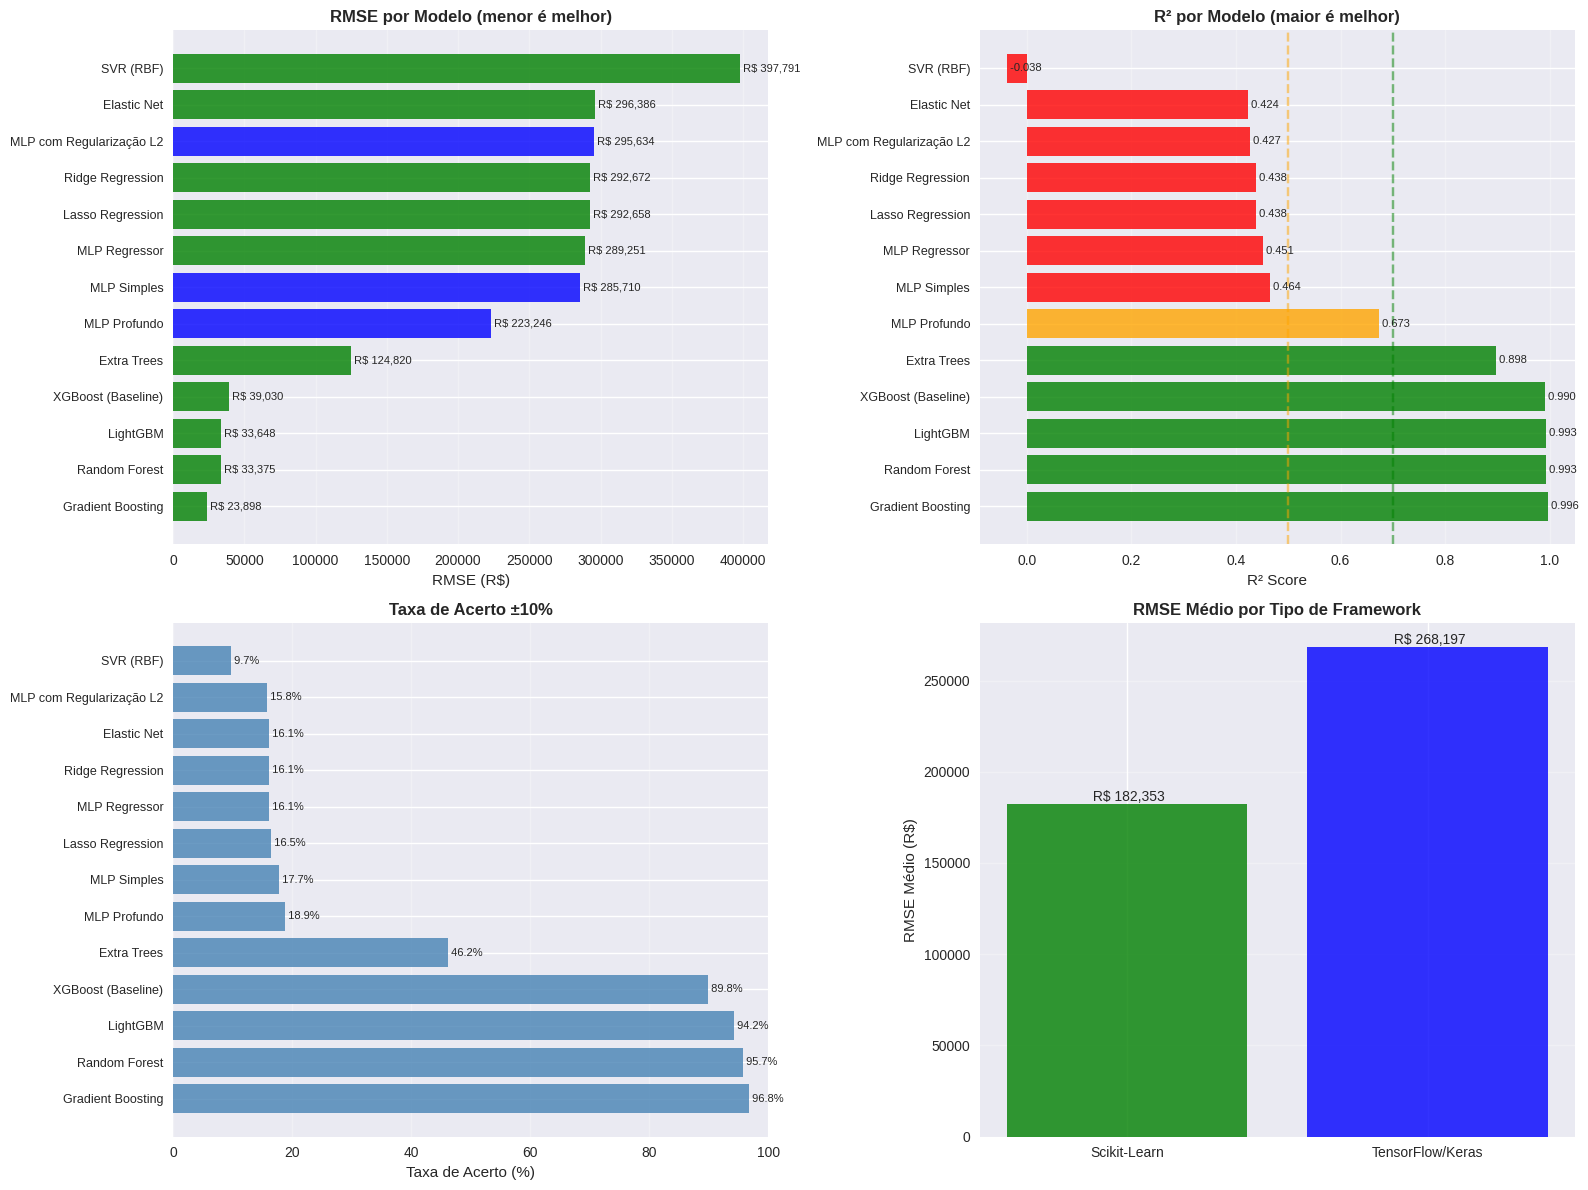


🏆 MELHOR MODELO DA COMPARAÇÃO
Modelo: Gradient Boosting
Tipo: Scikit-Learn
RMSE: R$ 23,898.28
R²: 0.9963
MAE: R$ 10,309.83
MAPE: 10.55%
Taxa de Acerto ±10%: 96.75%
Taxa de Acerto ±20%: 97.89%

✓ Comparação salva em: /content/dados_imoveis_teresina/modelos/comparacao_modelos_full.csv


In [59]:
# ============================================================================
# COMPARAÇÃO DE MODELOS TensorFlow e Scikit-Learn
# ============================================================================

if not results_df.empty and len(models_data) > 0:
    try:
        best_model_name = results_df.loc[results_df['rmse_test'].idxmin(), 'dataset']
    except:
        best_model_name = None

    if best_model_name and best_model_name in models_data:
        best_model_data = models_data[best_model_name]

        # Usar o dataset do melhor modelo para comparação
        print("="*80)
        print("COMPARAÇÃO DE MODELOS ALTERNATIVOS")
        print("="*80)
        print(f"\nUsando dataset: {best_model_name}")
        print(f"Amostras: {best_model_data['n_samples']}")
        print(f"Features: {best_model_data['n_features']}")

        # Carregar dados completos do dataset
        dataset_path = None
        for name, path in datasets:
            if name == best_model_name:
                dataset_path = path
                break

        if dataset_path and dataset_path.exists():
            df_comparison = pd.read_csv(dataset_path)
            target_col = 'Valor_Anuncio'
            X = df_comparison.drop(columns=[target_col]).select_dtypes(include=np.number)
            X = X.loc[:, X.var() > 0].dropna(axis=1)
            y = df_comparison[target_col]

            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42
            )

            # Normalizar para modelos que precisam
            from sklearn.preprocessing import StandardScaler
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            print(f"\nTreinando {len(X_train)} amostras, testando {len(X_test)} amostras...")

            # Dicionário para armazenar resultados
            comparison_results = []

            # ========================================================================
            # 1. MODELOS SCIKIT-LEARN
            # ========================================================================
            print("\n" + "="*80)
            print("TREINANDO MODELOS SCIKIT-LEARN")
            print("="*80)

            sklearn_models = {
                'Random Forest': RandomForestRegressor(
                    n_estimators=200,
                    max_depth=10,
                    min_samples_split=5,
                    min_samples_leaf=2,
                    random_state=42,
                    n_jobs=-1
                ),
                'Gradient Boosting': GradientBoostingRegressor(
                    n_estimators=200,
                    learning_rate=0.1,
                    max_depth=5,
                    random_state=42
                ),
                'Extra Trees': ExtraTreesRegressor(
                    n_estimators=200,
                    max_depth=10,
                    min_samples_split=5,
                    random_state=42,
                    n_jobs=-1
                ),
                'Ridge Regression': Ridge(alpha=1.0),
                'Lasso Regression': Lasso(alpha=0.1, max_iter=2000),
                'Elastic Net': ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=2000),
                'SVR (RBF)': SVR(kernel='rbf', C=100, gamma='scale', epsilon=0.1),
                'MLP Regressor': MLPRegressor(
                    hidden_layer_sizes=(100, 50),
                    activation='relu',
                    solver='adam',
                    alpha=0.001,
                    learning_rate='adaptive',
                    max_iter=500,
                    random_state=42,
                    early_stopping=True,
                    validation_fraction=0.1
                ),
                'LightGBM': LGBMRegressor(
                    n_estimators=200,
                    learning_rate=0.1,
                    max_depth=5,
                    random_state=42,
                    verbose=-1
                ),
                'XGBoost (Baseline)': XGBRegressor(
                    objective='reg:squarederror',
                    n_estimators=200,
                    learning_rate=0.08,
                    max_depth=4,
                    subsample=0.9,
                    colsample_bytree=0.9,
                    random_state=42
                )
            }

            for model_name, model in sklearn_models.items():
                try:
                    print(f"\n📦 Treinando {model_name}...")

                    # Alguns modelos precisam de dados normalizados
                    if model_name in ['Ridge Regression', 'Lasso Regression', 'Elastic Net',
                                     'SVR (RBF)', 'MLP Regressor']:
                        model.fit(X_train_scaled, y_train)
                        y_pred = model.predict(X_test_scaled)
                    else:
                        model.fit(X_train, y_train)
                        y_pred = model.predict(X_test)

                    # Calcular métricas
                    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                    mae = mean_absolute_error(y_test, y_pred)
                    r2 = r2_score(y_test, y_pred)

                    mask = y_test != 0
                    if mask.sum() > 0:
                        mape = mean_absolute_percentage_error(y_test[mask], y_pred[mask]) * 100
                        error_pct = np.abs((y_test[mask] - y_pred[mask]) / y_test[mask]) * 100
                        accuracy_10pct = (error_pct <= 10).mean() * 100
                        accuracy_20pct = (error_pct <= 20).mean() * 100
                    else:
                        mape = np.nan
                        accuracy_10pct = 0
                        accuracy_20pct = 0

                    comparison_results.append({
                        'modelo': model_name,
                        'tipo': 'Scikit-Learn',
                        'rmse': float(rmse),
                        'mae': float(mae),
                        'r2': float(r2),
                        'mape': float(mape) if not np.isnan(mape) else np.nan,
                        'accuracy_10pct': float(accuracy_10pct),
                        'accuracy_20pct': float(accuracy_20pct),
                        'tempo_treino': None  # Poderia adicionar timing
                    })

                    print(f"  ✓ RMSE: R$ {rmse:,.2f} | R²: {r2:.4f} | MAPE: {mape:.2f}%")

                except Exception as e:
                    print(f"  ✗ Erro ao treinar {model_name}: {str(e)}")

            # ========================================================================
            # 2. MODELOS TENSORFLOW/KERAS
            # ========================================================================
            if TENSORFLOW_AVAILABLE:
                print("\n" + "="*80)
                print("TREINANDO MODELOS TENSORFLOW/KERAS")
                print("="*80)

                tf_models_configs = [
                    {
                        'name': 'MLP Simples',
                        'layers': [
                            layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
                            layers.Dropout(0.2),
                            layers.Dense(64, activation='relu'),
                            layers.Dropout(0.2),
                            layers.Dense(32, activation='relu'),
                            layers.Dense(1)
                        ],
                        'epochs': 100,
                        'batch_size': 32
                    },
                    {
                        'name': 'MLP Profundo',
                        'layers': [
                            layers.Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
                            layers.BatchNormalization(),
                            layers.Dropout(0.3),
                            layers.Dense(128, activation='relu'),
                            layers.BatchNormalization(),
                            layers.Dropout(0.3),
                            layers.Dense(64, activation='relu'),
                            layers.Dropout(0.2),
                            layers.Dense(32, activation='relu'),
                            layers.Dense(1)
                        ],
                        'epochs': 150,
                        'batch_size': 32
                    },
                    {
                        'name': 'MLP com Regularização L2',
                        'layers': [
                            layers.Dense(128, activation='relu',
                                       kernel_regularizer=keras.regularizers.l2(0.01),
                                       input_shape=(X_train_scaled.shape[1],)),
                            layers.Dropout(0.2),
                            layers.Dense(64, activation='relu',
                                       kernel_regularizer=keras.regularizers.l2(0.01)),
                            layers.Dropout(0.2),
                            layers.Dense(1)
                        ],
                        'epochs': 100,
                        'batch_size': 32
                    }
                ]

                for config in tf_models_configs:
                    try:
                        print(f"\n📦 Treinando {config['name']}...")

                        # Criar modelo
                        model = models.Sequential(config['layers'])
                        model.compile(
                            optimizer=keras.optimizers.Adam(learning_rate=0.001),
                            loss='mse',
                            metrics=['mae']
                        )

                        # Callbacks
                        early_stop = callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=15,
                            restore_best_weights=True
                        )

                        # Treinar
                        history = model.fit(
                            X_train_scaled, y_train,
                            validation_split=0.2,
                            epochs=config['epochs'],
                            batch_size=config['batch_size'],
                            callbacks=[early_stop],
                            verbose=0
                        )

                        # Predizer
                        y_pred = model.predict(X_test_scaled, verbose=0).flatten()

                        # Calcular métricas
                        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                        mae = mean_absolute_error(y_test, y_pred)
                        r2 = r2_score(y_test, y_pred)

                        mask = y_test != 0
                        if mask.sum() > 0:
                            mape = mean_absolute_percentage_error(y_test[mask], y_pred[mask]) * 100
                            error_pct = np.abs((y_test[mask] - y_pred[mask]) / y_test[mask]) * 100
                            accuracy_10pct = (error_pct <= 10).mean() * 100
                            accuracy_20pct = (error_pct <= 20).mean() * 100
                        else:
                            mape = np.nan
                            accuracy_10pct = 0
                            accuracy_20pct = 0

                        comparison_results.append({
                            'modelo': config['name'],
                            'tipo': 'TensorFlow/Keras',
                            'rmse': float(rmse),
                            'mae': float(mae),
                            'r2': float(r2),
                            'mape': float(mape) if not np.isnan(mape) else np.nan,
                            'accuracy_10pct': float(accuracy_10pct),
                            'accuracy_20pct': float(accuracy_20pct),
                            'tempo_treino': None
                        })

                        print(f"  ✓ RMSE: R$ {rmse:,.2f} | R²: {r2:.4f} | MAPE: {mape:.2f}%")

                        # Limpar memória
                        del model
                        keras.backend.clear_session()

                    except Exception as e:
                        print(f"  ✗ Erro ao treinar {config['name']}: {str(e)}")
            else:
                print("\n⚠ TensorFlow não disponível. Pulando modelos de Deep Learning.")
                print("   Instale com: pip install tensorflow")

            # ========================================================================
            # 3. COMPARAÇÃO E RANKING
            # ========================================================================
            if comparison_results:
                comparison_df = pd.DataFrame(comparison_results)
                comparison_df = comparison_df.sort_values('rmse')

                print("\n" + "="*80)
                print("RANKING DE MODELOS (por RMSE)")
                print("="*80)

                display(comparison_df.round(2))

                # Visualização comparativa
                fig, axes = plt.subplots(2, 2, figsize=(16, 12))

                # 1. RMSE
                ax1 = axes[0, 0]
                sorted_rmse = comparison_df.sort_values('rmse')
                colors = ['green' if t == 'Scikit-Learn' else 'blue' for t in sorted_rmse['tipo']]
                ax1.barh(range(len(sorted_rmse)), sorted_rmse['rmse'], color=colors, alpha=0.8)
                ax1.set_yticks(range(len(sorted_rmse)))
                ax1.set_yticklabels(sorted_rmse['modelo'], fontsize=9)
                ax1.set_xlabel('RMSE (R$)', fontsize=11)
                ax1.set_title('RMSE por Modelo (menor é melhor)', fontsize=12, fontweight='bold')
                ax1.grid(axis='x', alpha=0.3)
                for i, v in enumerate(sorted_rmse['rmse']):
                    ax1.text(v, i, f' R$ {v:,.0f}', va='center', fontsize=8)

                # 2. R²
                ax2 = axes[0, 1]
                sorted_r2 = comparison_df.sort_values('r2', ascending=False)
                colors = ['green' if r2 > 0.7 else 'orange' if r2 > 0.5 else 'red'
                         for r2 in sorted_r2['r2']]
                ax2.barh(range(len(sorted_r2)), sorted_r2['r2'], color=colors, alpha=0.8)
                ax2.set_yticks(range(len(sorted_r2)))
                ax2.set_yticklabels(sorted_r2['modelo'], fontsize=9)
                ax2.set_xlabel('R² Score', fontsize=11)
                ax2.set_title('R² por Modelo (maior é melhor)', fontsize=12, fontweight='bold')
                ax2.grid(axis='x', alpha=0.3)
                ax2.axvline(x=0.7, color='green', linestyle='--', alpha=0.5)
                ax2.axvline(x=0.5, color='orange', linestyle='--', alpha=0.5)
                for i, v in enumerate(sorted_r2['r2']):
                    ax2.text(v, i, f' {v:.3f}', va='center', fontsize=8)

                # 3. Taxa de acerto ±10%
                ax3 = axes[1, 0]
                sorted_acc10 = comparison_df.sort_values('accuracy_10pct', ascending=False)
                ax3.barh(range(len(sorted_acc10)), sorted_acc10['accuracy_10pct'],
                        color='steelblue', alpha=0.8)
                ax3.set_yticks(range(len(sorted_acc10)))
                ax3.set_yticklabels(sorted_acc10['modelo'], fontsize=9)
                ax3.set_xlabel('Taxa de Acerto (%)', fontsize=11)
                ax3.set_title('Taxa de Acerto ±10%', fontsize=12, fontweight='bold')
                ax3.grid(axis='x', alpha=0.3)
                ax3.set_xlim([0, 100])
                for i, v in enumerate(sorted_acc10['accuracy_10pct']):
                    ax3.text(v, i, f' {v:.1f}%', va='center', fontsize=8)

                # 4. Comparação Scikit-Learn vs TensorFlow
                ax4 = axes[1, 1]
                tipo_avg = comparison_df.groupby('tipo')['rmse'].mean()
                ax4.bar(tipo_avg.index, tipo_avg.values, color=['green', 'blue'], alpha=0.8)
                ax4.set_ylabel('RMSE Médio (R$)', fontsize=11)
                ax4.set_title('RMSE Médio por Tipo de Framework', fontsize=12, fontweight='bold')
                ax4.grid(axis='y', alpha=0.3)
                for i, v in enumerate(tipo_avg.values):
                    ax4.text(i, v, f' R$ {v:,.0f}', ha='center', va='bottom', fontsize=10)

                plt.tight_layout()
                plt.show()

                # Melhor modelo
                best_comparison = comparison_df.iloc[0]
                print("\n" + "="*80)
                print("🏆 MELHOR MODELO DA COMPARAÇÃO")
                print("="*80)
                print(f"Modelo: {best_comparison['modelo']}")
                print(f"Tipo: {best_comparison['tipo']}")
                print(f"RMSE: R$ {best_comparison['rmse']:,.2f}")
                print(f"R²: {best_comparison['r2']:.4f}")
                print(f"MAE: R$ {best_comparison['mae']:,.2f}")
                if not np.isnan(best_comparison['mape']):
                    print(f"MAPE: {best_comparison['mape']:.2f}%")
                print(f"Taxa de Acerto ±10%: {best_comparison['accuracy_10pct']:.2f}%")
                print(f"Taxa de Acerto ±20%: {best_comparison['accuracy_20pct']:.2f}%")

                # Salvar comparação
                comparison_file = BEST_MODEL_DIR / f"comparacao_modelos_{best_model_name}.csv"
                comparison_df.to_csv(comparison_file, index=False)
                print(f"\n✓ Comparação salva em: {comparison_file}")
            else:
                print("\n⚠ Nenhum modelo foi treinado com sucesso.")
        else:
            print("Dataset não encontrado para comparação.")
    else:
        print("Melhor modelo não disponível para comparação.")
else:
    print("Execute as células anteriores primeiro para gerar a comparação de modelos.")


In [61]:
# ============================================================================
# RECOMENDAÇÕES FINAIS E RESUMO EXECUTIVO
# ============================================================================

print("="*80)
print("RESUMO EXECUTIVO E RECOMENDAÇÕES")
print("="*80)

if not results_df.empty:
    print("\n📊 RESUMO DA ANÁLISE:")
    print("-"*80)
    print(f"Total de datasets analisados: {len(results_df)}")
    print(f"Modelos treinados com sucesso: {len(results_df)}")

    if 'best_model_name' in globals() and best_model_name:
        best_row = results_df[results_df['dataset'] == best_model_name].iloc[0]

        print(f"\n🏆 MODELO SELECIONADO: {best_model_name}")
        print("-"*80)
        print(f"RMSE: R$ {best_row['rmse_test']:,.2f}")
        print(f"R²: {best_row['r2_test']:.4f}")
        print(f"MAE: R$ {best_row['mae_test']:,.2f}")
        if pd.notna(best_row.get('mape_test')):
            print(f"MAPE: {best_row['mape_test']:.2f}%")

        print("\n💡 RECOMENDAÇÕES DE MODELOS:")
        print("-"*80)

        # Avaliar qualidade do modelo atual
        r2_score = best_row['r2_test']

        if r2_score > 0.8:
            print("✓ Excelente desempenho! O modelo atual (XGBoost) está muito bom.")
            print("  Recomendações:")
            print("  - Manter XGBoost como modelo principal")
            print("  - Considerar ensemble de XGBoost + LightGBM para melhorar ainda mais")
            print("  - TensorFlow pode ser útil para capturar padrões não-lineares complexos")
        elif r2_score > 0.7:
            print("✓ Bom desempenho. O modelo atual está adequado.")
            print("  Recomendações:")
            print("  - Testar LightGBM (geralmente similar ou melhor que XGBoost)")
            print("  - Considerar Random Forest para interpretabilidade")
            print("  - TensorFlow pode ajudar se houver padrões complexos não capturados")
        elif r2_score > 0.5:
            print("⚠ Desempenho aceitável, mas há espaço para melhoria.")
            print("  Recomendações:")
            print("  - Testar LightGBM e Gradient Boosting (Scikit-Learn)")
            print("  - Considerar modelos de ensemble (Voting/Stacking)")
            print("  - TensorFlow com arquitetura mais profunda pode ajudar")
            print("  - Revisar features e engenharia de features")
        else:
            print("⚠ Desempenho baixo. Necessário melhorar o modelo.")
            print("  Recomendações:")
            print("  - Testar múltiplos algoritmos (Random Forest, Gradient Boosting, LightGBM)")
            print("  - Considerar TensorFlow com arquitetura profunda")
            print("  - Revisar e melhorar features")
            print("  - Verificar qualidade dos dados")
            print("  - Considerar coleta de mais dados")

        print("\n🔧 MODELOS RECOMENDADOS POR CENÁRIO:")
        print("-"*80)
        print("\n1. PRODUÇÃO (Performance + Estabilidade):")
        print("   - XGBoost ou LightGBM (já implementado)")
        print("   - Random Forest (mais estável, menos overfitting)")
        print("   - Gradient Boosting (Scikit-Learn)")

        print("\n2. INTERPRETABILIDADE:")
        print("   - Random Forest (feature importance)")
        print("   - Ridge/Lasso Regression (coeficientes interpretáveis)")

        print("\n3. DEEP LEARNING (Padrões Complexos):")
        print("   - TensorFlow/Keras MLP Profundo")
        print("   - TensorFlow com BatchNormalization e Dropout")
        print("   - Útil se houver relações não-lineares complexas")

        print("\n4. ENSEMBLE (Melhor Performance):")
        print("   - Stacking: XGBoost + LightGBM + Random Forest")
        print("   - Voting: Múltiplos modelos com média ponderada")

        print("\n📈 PRÓXIMOS PASSOS SUGERIDOS:")
        print("-"*80)
        print("1. Execute a célula de comparação de modelos para testar alternativas")
        print("2. Se TensorFlow estiver disponível, teste modelos de Deep Learning")
        print("3. Considere hyperparameter tuning (GridSearch/RandomSearch)")
        print("4. Implemente ensemble de modelos se performance for crítica")
        print("5. Monitore performance em produção e retreine periodicamente")

        print("\n🎯 MÉTRICAS ALVO SUGERIDAS:")
        print("-"*80)
        print("Para um sistema de predição de imóveis, considere:")
        print("- R² > 0.7: Bom")
        print("- R² > 0.8: Excelente")
        print("- Taxa de acerto ±10% > 60%: Aceitável")
        print("- Taxa de acerto ±20% > 80%: Bom")
        print("- MAPE < 20%: Aceitável")
        print("- MAPE < 15%: Bom")

        if pd.notna(best_row.get('mape_test')):
            if best_row['mape_test'] < 15:
                print(f"\n✓ Seu modelo atual tem MAPE de {best_row['mape_test']:.2f}% - EXCELENTE!")
            elif best_row['mape_test'] < 20:
                print(f"\n✓ Seu modelo atual tem MAPE de {best_row['mape_test']:.2f}% - BOM!")
            else:
                print(f"\n⚠ Seu modelo atual tem MAPE de {best_row['mape_test']:.2f}% - Considere melhorias")

    else:
        print("\n⚠ Modelo selecionado não disponível.")

    print("\n" + "="*80)
    print("Análise completa finalizada!")
    print("="*80)
else:
    print("\n⚠ Execute as células anteriores primeiro para gerar o resumo.")


RESUMO EXECUTIVO E RECOMENDAÇÕES

📊 RESUMO DA ANÁLISE:
--------------------------------------------------------------------------------
Total de datasets analisados: 2
Modelos treinados com sucesso: 2

🏆 MODELO SELECIONADO: full
--------------------------------------------------------------------------------
RMSE: R$ 39,029.81
R²: 0.9900
MAE: R$ 20,980.97
MAPE: 20.05%

💡 RECOMENDAÇÕES DE MODELOS:
--------------------------------------------------------------------------------
✓ Excelente desempenho! O modelo atual (XGBoost) está muito bom.
  Recomendações:
  - Manter XGBoost como modelo principal
  - Considerar ensemble de XGBoost + LightGBM para melhorar ainda mais
  - TensorFlow pode ser útil para capturar padrões não-lineares complexos

🔧 MODELOS RECOMENDADOS POR CENÁRIO:
--------------------------------------------------------------------------------

1. PRODUÇÃO (Performance + Estabilidade):
   - XGBoost ou LightGBM (já implementado)
   - Random Forest (mais estável, menos overfit